# Cambridge property modeling

An experimental notebook in which I throw a bunch of modeling at property valuation data, to learn something about Cambridge. Random forests were a convenient and reasonable place to start, and ended up doing rather well.

This notebook assumes completion of Cambridge_property_ETLC, output of which is used as input here. It's worth noting that the data had a rather large number of rows with obvious data entry problems. About 62% of the initial rows had some flaw that I identified during data cleaning. With such a large proportion, it's not possible to simply ignore known-bad rows. Instead, I replaced invalid values with NaNs and proceeded with whatever data appeared to be valid in each row.

For my data set, I used the Cambridge Assessing Department's on-line property database file for FY16, FY17, and FY18. It is supposed to include "residential, condo, commercial and exempt data". I wanted to use the available data to predict the city assessor's valuation in the future. In this data set, this column is called AssessedValue.

The original data set is available from the City of Cambridge. Go to the link below and click the "Export" button at the upper-right corner of the page:

https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY16-FY18/eey2-rv59

## Results of modeling

I settled on a random forest with 100 trees, which was nearly as accurate as a 300 tree model. When evaluated on a held-out validation set of 2018 properties, the mean absolute error was about 85,000; compared to a mean true value of 1,144,000, that is about 7.4% relative error. These values are for a model which was not allowed to consider PreviousAssessedValue, which seemed likely to be a major crutch. If allowed to use PreviousAssessedValue as a feature, the model achieved 3.5% relative error.

Inspection of residuals revealed that a large number of rows had AssessedValue == 0, and ALL of these rows also had invalid data in some other field that was detected during data cleaning. These data quality problems surely limited the accuracy of the model, and given their frequency, I was pleased how well the model still worked.

To aid interpretation of the model, I calculated feature importance using the RandomForestRegressor class attribute, then permuatation importance, then SHAP values. By any method, the most important feature was Interior_LivingArea, with several other important predictors grouped after it in an order that depends on the method. If PreviousAssessedValue is included in the model, it is the most important feature instead. Most of the important features contributed to AssessedValue in the expected way: AssessedValue tends to increase as SalePrice, Interior_LivingArea, etc., are increased.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap

# This variable will trigger filtering to just housing property types below, in cell 6.
# Initial analyses were somewhat confusing when I considered housing, commericial, and non-profit types together.
HOUSING_ONLY = True

## Load already-cleaned data, then do some light further transformation

In [2]:
# read in the data

df = pd.read_csv('./cleaned_properties.csv')
print(df.shape)

(86703, 63)


In [3]:
df.SaleDate = pd.to_datetime(df.SaleDate)

In [4]:
# These are the strings in df["PropertyClass"] that seem to indicate long-term housing.
# I excluded boarding house, dorm, hotel, parsonage, and other maybe-applicable categories.

housing_classes = [
                   'CONDO-BLDG', 'CONDOMINIUM', 'MULTIPLE-RES',
                   '4-8-UNIT-APT', 'MULT-RES->8 APT', 'TWO-FAM-RES', 'THREE-FM-RES',
                   'MULTIUSE-RES',
                   '>8-UNIT-APT', 'MULT-RES-4-8-APT',
                   'SNGL-FAM-RES',
                   'CNDO LUX', 
                   'MULT-RES-1FAM', 'MXD CONDOMINIUM',
                   'SINGLE FAM W/AUXILIARY APT', 'MULT-RES-2FAM',
                   'MULT-RES-3FAM',
                   'MULTI UNIT CNDO', 
                   'MXD >8-UNIT-APT',
                   'Housing',
                   'MXD 4-8-UNIT-APT',
                   'Housing, Other'
]

In [5]:
# Distinct housing properties (by PID) grouped by PropertyClass

df[df['PropertyClass'].isin(housing_classes)].groupby('PropertyClass')['PID'].count()

PropertyClass
4-8-UNIT-APT                   1769
>8-UNIT-APT                     888
CNDO LUX                       6513
CONDO-BLDG                     7912
CONDOMINIUM                   36217
Housing                           2
Housing, Other                    1
MULT-RES-1FAM                    38
MULT-RES-2FAM                    47
MULT-RES-3FAM                    31
MULT-RES-4-8-APT                156
MULT-RES->8 APT                  39
MULTI UNIT CNDO                   9
MULTIPLE-RES                    613
MULTIUSE-RES                    774
MXD 4-8-UNIT-APT                  4
MXD >8-UNIT-APT                   7
MXD CONDOMINIUM                   9
SINGLE FAM W/AUXILIARY APT      458
SNGL-FAM-RES                  11167
THREE-FM-RES                   3681
TWO-FAM-RES                    7387
Name: PID, dtype: int64

In [6]:
# Proceed with just rows representing housing.

if HOUSING_ONLY:
    df = df[df['PropertyClass'].isin(housing_classes)].reset_index(drop=True)
    

In [7]:
df['ValueIncrease'] = df['AssessedValue'] / df['PreviousAssessedValue'] - 1
df['AssessedValSqFoot'] = df['AssessedValue'] / df['Interior_LivingArea']
df['BuildingValRatio'] = df['BuildingValue'] / df['AssessedValue']

The tree methods don't handle datetimes as such, so instead I make derived columns of SaleMonth and SaleYear, both numeric for simplicity and limitation of dummy variables.

In [8]:
df['SaleMonth'] = df['SaleDate'].apply(lambda x: x.month)
df['SaleYear'] = df['SaleDate'].apply(lambda x: x.year)
df = df.drop(columns=['SaleDate'])

The Address field turned out to include latitude and longitude figures in every row from 2018, but not in 2017 or 2016. My first idea was to parse out the lat/lon from the 2018 rows and use them for the prior years, but that was overly clever: I don't plan to put more than one year on a map at a time. And many of the prior year rows had lat/lon, but often different in the 0.000X place. So I just took the lat/lon from each row's Address. If I need to be extremely complete in the future, I can go back through the 2016-2017 rows, find one that are missing lat/lon, and match by PID to the 2018 data... but I doubt that will be necessary.

In [9]:
# Extract lat/lon coordinates from Address; discard rows with no Address since they can't be used on map
df = df.dropna(subset=['Address']).reset_index(drop=True)

df['Coordinates'] = df['Address'].apply(lambda x: x.split('\n')[2])

# Create Latitude and Longitude columns
# I get a SettingWithCopyWarning, I think because df2018['Coordinates'] is a copy and it's unclear whether I
# mean to mutate it with .apply(). In this case I don't want to mutate and it's good that the copy gets thrown out!

def lat(x):
    if len(x) > 0:
        return float(x.split(',')[0].replace('(', ''))
    else:
        return np.nan
    
def lon(x):
    if len(x) > 0:
        return float(x.split(',')[1].replace(')', ''))
    else:
        return np.nan
    
df['Latitude'] = df['Coordinates'].apply(lat)
df['Longitude'] = df['Coordinates'].apply(lon)

# Drop the no longer needed Coordinates column
df = df.drop(columns=['Coordinates'])

In [10]:
df.columns

Index(['Unnamed: 0', 'PID', 'GISID', 'BldgNum', 'Address', 'Unit',
       'StateClassCode', 'PropertyClass', 'Zoning', 'Map/Lot', 'LandArea',
       'YearOfAssessment', 'TaxDistrict', 'ResidentialExemption',
       'BuildingValue', 'LandValue', 'AssessedValue', 'SalePrice', 'Book/Page',
       'PreviousAssessedValue', 'Owner_Name', 'Owner_CoOwnerName',
       'Owner_Location', 'Owner_Address', 'Owner_Address2', 'Owner_City',
       'Owner_State', 'Owner_Zip', 'Exterior_Style', 'Exterior_occupancy',
       'Exterior_NumStories', 'Exterior_WallType', 'Exterior_WallHeight',
       'Exterior_RoofType', 'Exterior_RoofMaterial', 'Exterior_FloorLocation',
       'Exterior_View', 'Interior_LivingArea', 'Interior_NumUnits',
       'Interior_TotalRooms', 'Interior_Bedrooms', 'Interior_Kitchens',
       'Interior_FullBaths', 'Interior_HalfBaths', 'Interior_Fireplaces',
       'Interior_Flooring', 'Interior_Layout', 'Interior_LaundryInUnit',
       'Systems_HeatType', 'Systems_HeatFuel', 'Systems_

## Modeling strategy

Before starting to model, I need to choose a data splitting and validation strategy. Since this model is forward-looking, I will use a similar approach to the one in APM with grant applications: For intitial training and model selection I will use all 2016-2017 data, testing on a portion of the 2018 data. Once the model is selected, I will retrain on the 2016-2017 plus testing 2018 data, and evaluate on a held-out portion of 2018 validation data.

For now, I will do random forests and ignore issues with NAs.

Features I will drop because they don't plausibly contain relevant information, or are too confounded with the target variable AssessedValue:
* PID
* GISID
* Address
* Unit -- the data has datetime values in it! -- just a mess
* Map/lot
* BuildingValue (too confounded with AssessedValue)
* LandValue (too confounded with AssessedValue)
* Book/Page
* Owner_Name
* Owner_CoOwnerName
* Owner_Location
* Owner_Address
* Owner_Address2
* Owner_City
* Owner_State
* Owner_Zip
* Modified (although it's tempting to deemphasize rows that are known to have contained invalid values)
* ValueIncrease (for now, but might be useful if I unstack years to put one parcel per row)
* AssessedValSqFoot (too confounded with AssessedValue)

Thus, features I will keep:

In [11]:
feature_list = ['BldgNum',
       'StateClassCode', 'PropertyClass', 'Zoning', 'LandArea',
       'YearOfAssessment', 'TaxDistrict', 'ResidentialExemption',
       'SalePrice', 
       'SaleMonth', 'SaleYear',
       'PreviousAssessedValue', 
       'Exterior_Style', 'Exterior_occupancy',
       'Exterior_NumStories', 'Exterior_WallType', 'Exterior_WallHeight',
       'Exterior_RoofType', 'Exterior_RoofMaterial', 'Exterior_FloorLocation',
       'Exterior_View', 'Interior_LivingArea', 'Interior_NumUnits',
       'Interior_TotalRooms', 'Interior_Bedrooms', 'Interior_Kitchens',
       'Interior_FullBaths', 'Interior_HalfBaths', 'Interior_Fireplaces',
       'Interior_Flooring', 'Interior_Layout', 'Interior_LaundryInUnit',
       'Systems_HeatType', 'Systems_HeatFuel', 'Systems_CentralAir',
       'Systems_Plumbing', 'Condition_YearBuilt',
       'Condition_InteriorCondition', 'Condition_OverallCondition',
       'Condition_OverallGrade', 'Parking_Open', 'Parking_Covered',
       'Parking_Garage', 'UnfinishedBasementGross', 'FinishedBasementGross',
       'Latitude',
       'Longitude']

In [12]:
X = df[feature_list]

In [13]:
X.columns

Index(['BldgNum', 'StateClassCode', 'PropertyClass', 'Zoning', 'LandArea',
       'YearOfAssessment', 'TaxDistrict', 'ResidentialExemption', 'SalePrice',
       'SaleMonth', 'SaleYear', 'PreviousAssessedValue', 'Exterior_Style',
       'Exterior_occupancy', 'Exterior_NumStories', 'Exterior_WallType',
       'Exterior_WallHeight', 'Exterior_RoofType', 'Exterior_RoofMaterial',
       'Exterior_FloorLocation', 'Exterior_View', 'Interior_LivingArea',
       'Interior_NumUnits', 'Interior_TotalRooms', 'Interior_Bedrooms',
       'Interior_Kitchens', 'Interior_FullBaths', 'Interior_HalfBaths',
       'Interior_Fireplaces', 'Interior_Flooring', 'Interior_Layout',
       'Interior_LaundryInUnit', 'Systems_HeatType', 'Systems_HeatFuel',
       'Systems_CentralAir', 'Systems_Plumbing', 'Condition_YearBuilt',
       'Condition_InteriorCondition', 'Condition_OverallCondition',
       'Condition_OverallGrade', 'Parking_Open', 'Parking_Covered',
       'Parking_Garage', 'UnfinishedBasementGross', 'F

In [14]:
[(c, X[c].dtype) for c in X]

[('BldgNum', dtype('int64')),
 ('StateClassCode', dtype('int64')),
 ('PropertyClass', dtype('O')),
 ('Zoning', dtype('O')),
 ('LandArea', dtype('float64')),
 ('YearOfAssessment', dtype('int64')),
 ('TaxDistrict', dtype('O')),
 ('ResidentialExemption', dtype('O')),
 ('SalePrice', dtype('float64')),
 ('SaleMonth', dtype('float64')),
 ('SaleYear', dtype('float64')),
 ('PreviousAssessedValue', dtype('float64')),
 ('Exterior_Style', dtype('O')),
 ('Exterior_occupancy', dtype('O')),
 ('Exterior_NumStories', dtype('float64')),
 ('Exterior_WallType', dtype('O')),
 ('Exterior_WallHeight', dtype('float64')),
 ('Exterior_RoofType', dtype('O')),
 ('Exterior_RoofMaterial', dtype('O')),
 ('Exterior_FloorLocation', dtype('float64')),
 ('Exterior_View', dtype('O')),
 ('Interior_LivingArea', dtype('float64')),
 ('Interior_NumUnits', dtype('float64')),
 ('Interior_TotalRooms', dtype('float64')),
 ('Interior_Bedrooms', dtype('float64')),
 ('Interior_Kitchens', dtype('O')),
 ('Interior_FullBaths', dtype('float64')),
 ('Interior_HalfBaths', dtype('float64')),
 ('Interior_Fireplaces', dtype('float64')),
 ('Interior_Flooring', dtype('O')),
 ('Interior_Layout', dtype('O')),
 ('Interior_LaundryInUnit', dtype('O')),
 ('Systems_HeatType', dtype('O')),
 ('Systems_HeatFuel', dtype('O')),
 ('Systems_CentralAir', dtype('O')),
 ('Systems_Plumbing', dtype('O')),
 ('Condition_YearBuilt', dtype('float64')),
 ('Condition_InteriorCondition', dtype('O')),
 ('Condition_OverallCondition', dtype('O')),
 ('Condition_OverallGrade', dtype('O')),
 ('Parking_Open', dtype('float64')),
 ('Parking_Covered', dtype('float64')),
 ('Parking_Garage', dtype('float64')),
 ('UnfinishedBasementGross', dtype('float64')),
 ('FinishedBasementGross', dtype('float64')),
 ('Latitude', dtype('float64')),
 ('Longitude', dtype('float64'))]

I need to dummy the qualitative variables, which I hope won't explode the column count too much. I could also return to cleaning to recode synonyms / capitalizations, but skip for now.

In [15]:
X.shape

(77715, 47)

Apparently I can't use NaN or np.inf values in the float columns! Options:
* Impute
* Ignore these rows
* Put in a marker for "invalid value" that is numeric.

I chose the last option and used -9.

In [16]:
for c in X.select_dtypes(include='number'):
    count_missing = X[c].isna().sum()
    if count_missing > 0:
        print(f"NAs in {c}: {count_missing}")
        
    

NAs in LandArea: 2
NAs in SaleMonth: 25924
NAs in SaleYear: 25924
NAs in PreviousAssessedValue: 1
NAs in Exterior_NumStories: 9
NAs in Exterior_WallHeight: 74188
NAs in Exterior_FloorLocation: 35996
NAs in Interior_LivingArea: 9
NAs in Interior_NumUnits: 42758
NAs in Interior_TotalRooms: 3525
NAs in Interior_Bedrooms: 3532
NAs in Interior_FullBaths: 3534
NAs in Interior_HalfBaths: 3534
NAs in Interior_Fireplaces: 3534
NAs in Condition_YearBuilt: 8253
NAs in Parking_Open: 3534
NAs in Parking_Covered: 3534
NAs in Parking_Garage: 34959
NAs in UnfinishedBasementGross: 9
NAs in FinishedBasementGross: 3527
NAs in Latitude: 1679
NAs in Longitude: 1679


In [17]:
for c in X.select_dtypes(include='number'):
    missing_mask = X[c].isna()
    X.loc[missing_mask, c] = -9
    
print("Done!\n")

for c in X.select_dtypes(include='number'):
    count_missing = X[c].isna().sum()
    if count_missing > 0:
        print(f"NAs in {c}: {count_missing}")
        
print("Done again!")

Done!

Done again!


In [18]:
# one-hot encode with pd.get_dummies

X = pd.get_dummies(X, dummy_na=True)

In [19]:
X.shape

(77715, 404)

## Split data according to the two-stage hold-out strategy

I randomly picked a sub-sample of the FY2018 rows to be the final validation data. In the split below, X_val and y_val are this final validation set, used only at the very end to evaluate how good the final model is. X_train and y_train are used as the test set during hyperparameter tuning. They are added to the training data for final model training.

In [20]:
y = df.AssessedValue

In [21]:
mask_2018 = X['YearOfAssessment']==2018
X_2018 = X[mask_2018]
y_2018 = y[mask_2018]

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_2018, y_2018, random_state=1, test_size=0.25)
# I am making the default explicit: normally test/train ratio is 0.25

In [23]:
mask_selection = X['YearOfAssessment'].isin([2016, 2017])
X_selection = X[mask_selection]
y_selection = y[mask_selection]

## First random forest model

In [24]:
rf_model = RandomForestRegressor(n_estimators = 10, max_features = 'sqrt',
                                random_state = 1)

In [25]:
t1 = time.time()
rf_model.fit(X_selection, y_selection)
t2 = time.time()
print(f"Elapsed time: {t2-t1} seconds.")

Elapsed time: 3.3964500427246094 seconds.


In [26]:
y_pred_2018 = rf_model.predict(X_train)
e = mean_squared_error(y_pred_2018, y_train)
print(f"MSE: {e}")

print(f"RMS error: {(e)**0.5}")

mae = mean_absolute_error(y_pred_2018, y_train)
print(f"MAE: {mae}")

print(f"Mean value of observed y: {y_train.mean()}")

print(f"MAE / mean observed y: {mae / y_train.mean()}")

MSE: 570121999695.5459
RMS error: 755064.2354763903
MAE: 100938.34008124229
Mean value of observed y: 1068624.0089469354
MAE / mean observed y: 0.09445636560300656


In [27]:
print("Observed \t Predicted \t Fractional error")
for i in range(20):
    print(y_train.iloc[i], "\t", y_pred_2018[i], '\t', (-y_train.iloc[i] + y_pred_2018[i]) / y_pred_2018[i])

Observed 	 Predicted 	 Fractional error
1667900.0 	 1598210.0 	 -0.043605033130815096
832400.0 	 813930.0 	 -0.022692369122651827
608500.0 	 575100.0 	 -0.058076856198921924
399500.0 	 357750.0 	 -0.116701607267645
586700.0 	 589680.0 	 0.00505358838692172
1879500.0 	 1812440.0 	 -0.036999845512127295
582200.0 	 560750.0 	 -0.03825234061524744
987500.0 	 882410.0 	 -0.11909429856869255
568100.0 	 587320.0 	 0.03272491997548185
412000.0 	 397060.0 	 -0.03762655518057724
1938800.0 	 1738240.0 	 -0.11538107511045656
613700.0 	 592690.0 	 -0.03544854814489868
1108400.0 	 1060360.0 	 -0.04530536798823041
1048200.0 	 985310.0 	 -0.06382762785316297
0.0 	 0.0 	 nan
0.0 	 0.0 	 nan
488100.0 	 469180.0 	 -0.0403256745811842
506700.0 	 485450.0 	 -0.04377381810691111
1518800.0 	 1414080.0 	 -0.07405521611224258
639000.0 	 616800.0 	 -0.03599221789883268


## Vary model hyperparameters to improve performance

OK, now that the first model is working, it's time to loop through model hyperparameters trying to improve predictions!

In [28]:
# for n in [10, 30, 100, 300]:
#     t1 = time.time()
#     rf = RandomForestRegressor(n_estimators=n, max_features = 'sqrt', random_state=1)
#     rf.fit(X_selection, y_selection)
#     y_pred = rf.predict(X_train)
#     mae = mean_absolute_error(y_pred, y_train)
#     print(f"Number of estimators: {n}")
#     print(f"MAE: {mae}")
#     print(f"Mean value of observed y: {y_train.mean()}")
#     print(f"MAE / Mean(y): {mae/y_train.mean()}")
#     t2 = time.time()
#     print(f"Elapsed time: {t2-t1} seconds.")

Output of the above (skipped now that I know):

```Number of estimators: 10
MAE: 100938.34008124229
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.09445636560300656
Elapsed time: 3.995140314102173 seconds.
Number of estimators: 30
MAE: 91609.39273961332
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.08572649685261036
Elapsed time: 9.943724155426025 seconds.
Number of estimators: 100
MAE: 85821.05122737556
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.08030986624748122
Elapsed time: 28.508166074752808 seconds.
Number of estimators: 300
MAE: 87193.46797179944
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.08159415027341876
Elapsed time: 92.42772102355957 seconds.
```

As the number of estimators increases, compute time rises linearly but mean absolute error faces very diminishing return. In fact, 300 estimators did slightly worse than 100.

Let's also see if a different number for max_features does anything. I will use 1/3 of the features each time, which I found recommended in ISLR for regression problems -- the sqrt(n) standard I used above was recommended for classification trees, and I had misremembered it. In this case, since I have many dummied columns, using a larger fraction of hte predictors makes sense.

In [29]:
# for n in [10, 30, 100, 300]:
#     t1 = time.time()
#     rf = RandomForestRegressor(n_estimators=n, max_features = 0.33, random_state=1)
#     rf.fit(X_selection, y_selection)
#     y_pred = rf.predict(X_train)
#     mae = mean_absolute_error(y_pred, y_train)
#     print(f"Number of estimators: {n}")
#     print(f"MAE: {mae}")
#     print(f"Mean value of observed y: {y_train.mean()}")
#     print(f"MAE / Mean(y): {mae/y_train.mean()}")
#     t2 = time.time()
#     print(f"Elapsed time: {t2-t1} seconds.")

The results from the cell above, if run:

```
Number of estimators: 10
MAE: 66113.019616413
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.06186742863990432
Elapsed time: 8.50192904472351 seconds.
Number of estimators: 30
MAE: 60363.955745235166
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.05648755337690776
Elapsed time: 34.347939014434814 seconds.
Number of estimators: 100
MAE: 59325.91286867544
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.05551617067553775
Elapsed time: 83.42667484283447 seconds.
Number of estimators: 300
MAE: 58311.34205762375
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.054566752730070195
Elapsed time: 221.66778111457825 seconds.
```


With fractional error now down to about 5.5%, this was a clear improvement! Going to increased number of estimators is not buying very much in this case, though. I will stick with 100 trees in this forest, which yielded improvement in the X,000 digit compared to 30 trees, but going to 300 trees improved only by X00.

## Using chosen hyperparameters, refit model to the full training data set, and evaluate using the final hold-out set.

Now that I've determined the number of trees and predictors, it's time to refit using the chosen hyperparameters, including the first part of 2018 data in training, and evaluate on the held-out 2018 validation data.

In [28]:
X_final_train = pd.concat([X_selection, X_train])
y_final_train = pd.concat([y_selection, y_train])

t1 = time.time()
rf = RandomForestRegressor(n_estimators=100, max_features = 0.33, random_state=1)
rf.fit(X_final_train, y_final_train)
y_pred = rf.predict(X_val)
mae = mean_absolute_error(y_pred, y_val)
print(f"Number of estimators: 100")
print(f"MAE: {mae}")
print(f"Mean value of observed y: {y_val.mean()}")
print(f"MAE / Mean(y): {mae/y_val.mean()}")
t2 = time.time()
print(f"Elapsed time: {t2-t1} seconds.")

Number of estimators: 100
MAE: 40169.827780348605
Mean value of observed y: 1143609.037791146
MAE / Mean(y): 0.03512548996459112
Elapsed time: 112.20722889900208 seconds.


Validation on the held-out 2018 data yielded a fractional error of 3.5%, or a mean absolute error of \$ 40,000 on a mean observed assessment of 1.1M, which is getting quite good. 

Aside: this performance is comparable to but slightly worse than the version that left out SaleMonth and SaleYear. In that case, MAE was 36,002.

## Explore what factors drive the model performance

Now let's see what aspects of the model are driving it. First, check feature_importances_ as an attribute of the RandomForestRegressor.

In [29]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_final_train.columns,
                                   columns=['importance']).sort_values('importance',
                                   ascending=False)

In [30]:
feature_importances.query('importance > 0.002')

,importance
PreviousAssessedValue,0.414579
Interior_LivingArea,0.199755
Interior_NumUnits,0.087695
Exterior_NumStories,0.065616
SalePrice,0.043641
LandArea,0.038571
Exterior_Style_APTS-LUXURY,0.018064
Condition_YearBuilt,0.012987
Exterior_occupancy_>8-UNIT-APT,0.009883
Longitude,0.008767


The most important feature, intuitively, is PreviousAssessedValue. If we assume that property valuations don't change greatly from one year to the next, we should expect that the model leans heavily on this feature.

## Redo model without using PreviousAssessedValue

We excluded a number of features that were strongly confounded with AssessedValue, to avoid sneaking the answer into the model directly but inadvertently. It's possible we did something similar with PreviousAssessedValue, so it will be interesting to see how much performance we lose when the model is not allowed to use that feature.

In [31]:
X = X.drop(columns=['PreviousAssessedValue'])

In [32]:
mask_2018 = X['YearOfAssessment']==2018
X_2018 = X[mask_2018]
y_2018 = y[mask_2018]

X_train, X_val, y_train, y_val = train_test_split(X_2018, y_2018, random_state=1, test_size=0.25)
# I am making the default explicit: normally test/train ratio is 0.25

mask_selection = X['YearOfAssessment'].isin([2016, 2017])
X_selection = X[mask_selection]
y_selection = y[mask_selection]

In [33]:
# for n in [10, 30, 100, 300]:
#     t1 = time.time()
#     rf = RandomForestRegressor(n_estimators=n, max_features = 0.33, random_state=1)
#     rf.fit(X_selection, y_selection)
#     y_pred = rf.predict(X_train)
#     mae = mean_absolute_error(y_pred, y_train)
#     print(f"Number of estimators: {n}")
#     print(f"MAE: {mae}")
#     print(f"Mean value of observed y: {y_train.mean()}")
#     print(f"MAE / Mean(y): {mae/y_train.mean()}")
#     t2 = time.time()
#     print(f"Elapsed time: {t2-t1} seconds.")

As expected, it's worse, but perhaps less worse than I feared. Typical fractional error is 10%, compared to 5-6%. Output of the above cell:

```
Number of estimators: 10
MAE: 111412.00631158058
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.10425744263538529
Elapsed time: 8.24483871459961 seconds.
Number of estimators: 30
MAE: 106922.89904999683
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.10005661313501922
Elapsed time: 25.108657121658325 seconds.
Number of estimators: 100
MAE: 105615.82652720646
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.09883347710976893
Elapsed time: 80.88468503952026 seconds.
Number of estimators: 300
MAE: 104580.77715593057
Mean value of observed y: 1068624.0089469354
MAE / Mean(y): 0.09786489567924703
Elapsed time: 266.3848440647125 seconds.
```

Retrain on the full data using the best hyperparameters.

In [34]:
X_final_train = pd.concat([X_selection, X_train])
y_final_train = pd.concat([y_selection, y_train])

t1 = time.time()
rf = RandomForestRegressor(n_estimators=100, max_features = 0.33, random_state=1)
rf.fit(X_final_train, y_final_train)
y_pred = rf.predict(X_val)
mae = mean_absolute_error(y_pred, y_val)
print(f"Number of estimators: 100")
print(f"MAE: {mae}")
print(f"Mean value of observed y: {y_val.mean()}")
print(f"MAE / Mean(y): {mae/y_val.mean()}")
t2 = time.time()
print(f"Elapsed time: {t2-t1} seconds.")

Number of estimators: 100
MAE: 84887.66084014603
Mean value of observed y: 1143609.037791146
MAE / Mean(y): 0.07422786812187541
Elapsed time: 108.60128784179688 seconds.


Somewhat amazingly, fractional error only went up to 7.4% here.

Get feature importances from the model having no PreviousAssessedValue -- note that it includes SalePrice, but that price can be quite far in the past.

In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_final_train.columns,
                                   columns=['importance']).sort_values('importance',
                                   ascending=False)

feature_importances.query('importance > 0.002')

,importance
Interior_LivingArea,0.318177
Interior_NumUnits,0.159379
Exterior_NumStories,0.084103
LandArea,0.080741
SalePrice,0.072539
Exterior_Style_APTS-LUXURY,0.050741
Condition_YearBuilt,0.019873
Exterior_occupancy_>8-UNIT-APT,0.015873
Longitude,0.013091
Interior_Bedrooms,0.011609


Quite reasonably, SalePrice is now rather important, and SaleYear is on the list, I expect as a mechanism for weighting SalePrice. Many of the other important features seem to show that bigger properties are more expensive, which is intuitive.

## Inspect the model

To see if we have left in any major systematic errors, it's time to look at the model residuals in a few ways. First, I'll look at the residuals versus the known values of AssessedValue.

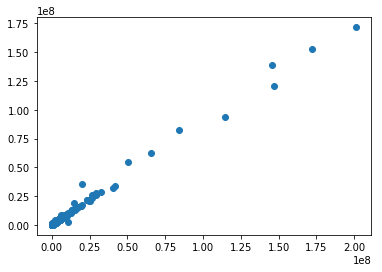

In [36]:
plt.scatter(y_val, y_pred)
plt.show()

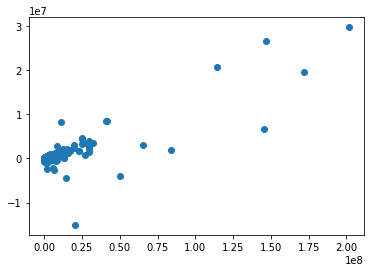

In [37]:
resid = y_val - y_pred
plt.scatter(y_val, resid)
plt.show()

There's a clear trend of under-predicting for more expensive properties, especially the top 10 or so most expensive ones.

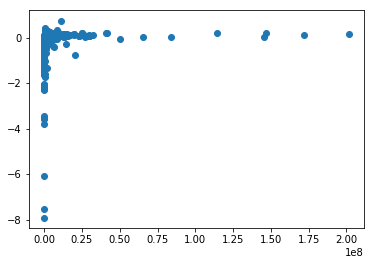

In [38]:
norm_resid = resid / y_val
plt.scatter(y_val, norm_resid,)

The residual relative to the property value, however, doesn't increase much with scale.

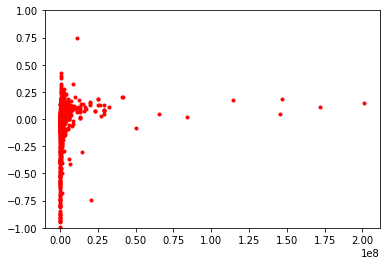

In [39]:
plt.plot(y_val, norm_resid, 'r.')
plt.ylim(-1,1)
plt.show()

There is a much wider range of residuals in the less expensive properties, but then again, they are by far the bulk of the data.

## Plot residuals on a geographic map

Because this data set refers to a physical space, it's possible to visualize on a geographic map. If particular neighborhoods stand out, we could look for the underlying reasons, such as school district boundaries, areas of high crime, vulnerability to flooding, or many other plausible things.

In [40]:
import mapboxgl
import pysal.esda.mapclassify as mapclassify
token = 'pk.eyJ1IjoibWJyb21hbm93c2t5IiwiYSI6ImNqbHk2NHIwcTFvNG4za29kaXptdGx4eHcifQ.1wudvgV_q8udxQXadRTrpw'

In [41]:
norm_resid.name='norm_residuals'

mask_val = X_val.index
df_to_plot = df.loc[mask_val]
df_to_plot = df_to_plot.assign(norm_residuals=norm_resid)

# Drop rows that are missing lat/lon, which can't be plotted

mask = df_to_plot['Latitude'].isna()
df_plottable = df_to_plot[~mask].reset_index(drop=True)

# Export to geojson: lat/lon for mapping, plus the top several predictors according to feature_importance,
# plus y_val and norm_resid and values derived from AssessedValue. Also the "Modified" column.

mapboxgl.utils.df_to_geojson(df_plottable, filename='output/error_plot_no_prev.geojson',
                properties=['Interior_LivingArea', 'Interior_NumUnits', 'Exterior_NumStories',
                            'LandArea', 'SalePrice', 'Exterior_Style', 'Condition_YearBuilt',
                            'Exterior_occupancy', 'Interior_Bedrooms', 'Interior_FullBaths',
                            'AssessedValue', 'norm_residuals', 'AssessedValSqFoot', 'ValueIncrease',
                            'BuildingValRatio', 'Modified'],
                lat='Latitude', lon='Longitude', precision=7)

{'type': 'file',
 'filename': 'output/error_plot_no_prev.geojson',
 'feature_count': 6483}

In [42]:
# helper functions for mapping

def reverse_stops(color_stops):
    li = list(zip(*color_stops))
    rev_stops = [li[0], tuple(reversed(li[1]))]
    new_stops = list(zip(*rev_stops))
    new_stops_list = [list(i) for i in new_stops]
    return new_stops_list

def make_map(feature = 'norm_residuals'):
    
    # set seed to ensure my fixed scale is actually repeated!
    
    np.random.seed(123456)
        
    mask =( (df_plottable['AssessedValSqFoot'] != np.inf) & (~df_plottable['AssessedValSqFoot'].isna()) &
           (~df_plottable['AssessedValue'].isna()) & (~df_plottable['norm_residuals'].isna()) )
    df_masked = df_plottable[mask]
    color_breaks = mapclassify.Natural_Breaks(df_masked[feature], k=8, initial = 1).bins
    color_stops = mapboxgl.utils.create_color_stops(color_breaks, colors='RdYlBu')
    viz = mapboxgl.viz.CircleViz('output/error_plot_no_prev.geojson',
                                access_token = token,
                                height='700px',
                                color_property=feature,
                                color_stops=reverse_stops(color_stops),
                                center=(-71.11, 42.375),
                                zoom=12.5)
    
    viz.show()
    return viz

In [43]:
viz = make_map(feature='norm_residuals')

Below is a still PNG version of the live map.

![residual_map.png](images/residual_map.png)

## Interpretation of invalid map points

That is quite a lot of black dots! They are properties that have lat/lon and can therefore be plotted on the map, but their norm_residuals values are invalid. By inspection, they appear all to be AssessedValue == 0 and therefore norm_residual == -np.inf, which is interpreted as null by Mapbox. As show in the next cell, EVERY point which has AssessedValue == 0 also had its Modified flag set during data cleaning, showing that some other field had an invalid value. Thus, I believe all of these invalid points represent data entry errors.

In [44]:
df_plottable.query('AssessedValue == 0').Modified.unique()

array([ True])

In [45]:
df_to_plot[df_to_plot.norm_residuals != -np.inf].norm_residuals.apply(abs).mean()

0.06777077525965079

If we consider only the rows that have nonzero AssessedValues, the mean absolute normed residuals are only about 6.8% of the true AssessedValue. Note that this is for the model which was not allowed to use PreviousAssessedValue as a feature.

In [46]:
df_to_plot['abs_norm_residuals'] = df_to_plot['norm_residuals'].apply(abs)

Ignoring the NaN values in abs_norm_residuals, we can split rows into two bins, one for "high error" with abs_norm_residual more than 2x the mean value, and the rest in a "low error" bin. What is the rate of row modification in each bin?

In [50]:
mask = df_to_plot.abs_norm_residuals > 0.068
df_to_plot.groupby(mask)[['Modified']].mean()

,Modified
abs_norm_residuals,
False,0.444617
True,0.430163


The modification rate is barely different! So it doesn't seem that error is especially driven by presence of invalid data.

## What drives the model?

The random forest model is working decently well, but it is not very interpretable by itself. Below, I try three approaches to open the black box:
* Permutation importance: how much does the model suffer if we shuffle one feature at a time?
* Partial dependence plots: how much does the model prediction change, on average, when we ramp through values for one feature at a time?
* SHAP values: for a given prediction or set of predictions, how can we assign importance to each of the features? Frank admission: I don't yet understand how this works, but the data science community seems very excited about it.

### Permutation importance

Here, I looked at the Permutation Importance measure, which calculates the decrease in model accuracy when the validation data are run through the model, but with one column at a time having its values shuffled. With so many columns, this took a long while to run: about 10 minutes for this data set.

In [53]:
# perm = PermutationImportance(rf, random_state=1).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Permutation importance yielded this result (copy-pasted so I can get the result without rerunning every time):

`
0.4319 ± 0.0127	Interior_LivingArea
0.0746 ± 0.0013	Exterior_NumStories
0.0536 ± 0.0061	Exterior_occupancy_>8-UNIT-APT
0.0534 ± 0.0016	Interior_NumUnits
0.0532 ± 0.0042	LandArea
0.0310 ± 0.0002	SalePrice
0.0166 ± 0.0002	Interior_TotalRooms
0.0161 ± 0.0001	Interior_FullBaths
0.0157 ± 0.0002	Interior_Bedrooms
0.0121 ± 0.0000	Exterior_Style_APTS-LUXURY
0.0111 ± 0.0017	Condition_YearBuilt
0.0089 ± 0.0022	Longitude
0.0087 ± 0.0004	PropertyClass_>8-UNIT-APT
0.0073 ± 0.0024	Latitude
0.0052 ± 0.0014	Exterior_Style_APARTMENTS
0.0036 ± 0.0007	Exterior_occupancy_nan
0.0035 ± 0.0000	Zoning_C-3
0.0031 ± 0.0000	Exterior_WallType_BRICK
0.0023 ± 0.0000	Systems_HeatType_FORCED-AIR
0.0021 ± 0.0001	BldgNum
… 383 more …
`

The top several features are the same set as was identified by feature_importance, but listed in a different rank order. Interior_LivingArea is the top in both lists.

### Partial dependence plots

Now, do partial dependence plots on a few of the more important features. I will first do single-feature plots, and then a few combinations of 2 features. I especially want to look at the latitude/longitude contour plot and compare it to the map visualizations I did earlier.

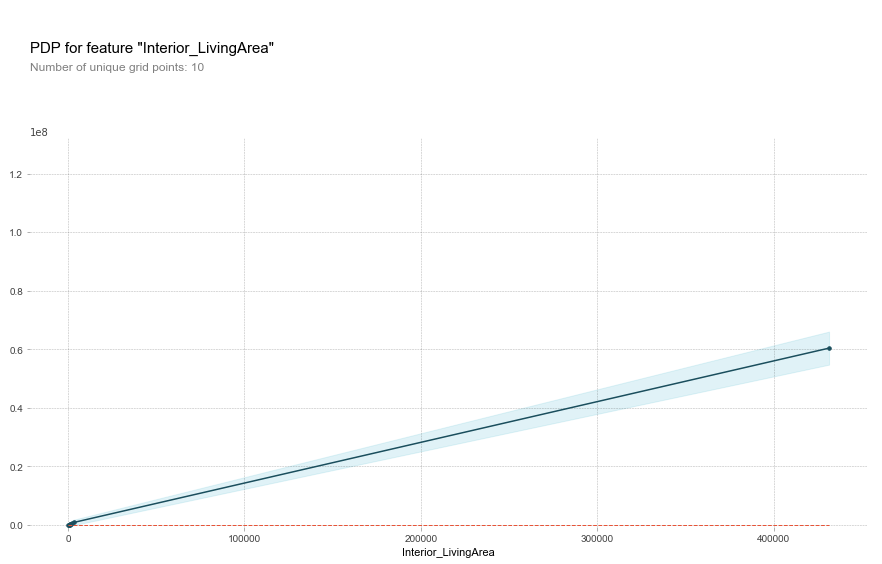

Elapsed time: 4.579744338989258 seconds.


In [54]:
feat_names = X_val.columns.tolist()

# First, look at PreviousAssessedValue. I guess monotonic and linear.

t1 = time.time()
pdp_rf = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feat_names,
                         feature="Interior_LivingArea")
pdp.pdp_plot(pdp_rf, 'Interior_LivingArea')
plt.show()
t2 = time.time()
print(f"Elapsed time: {t2-t1} seconds.")

In [55]:
top_features = feature_importances.query('importance > 0.002').index.tolist()

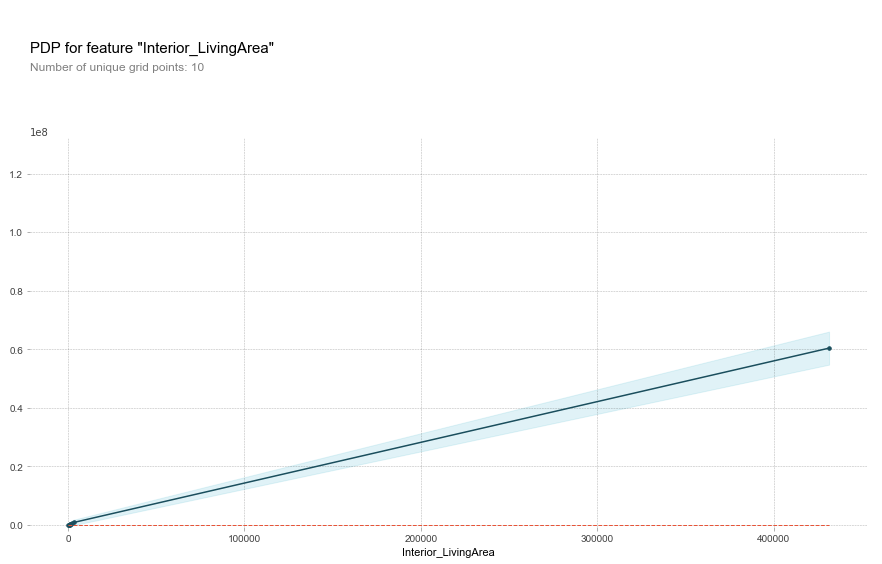

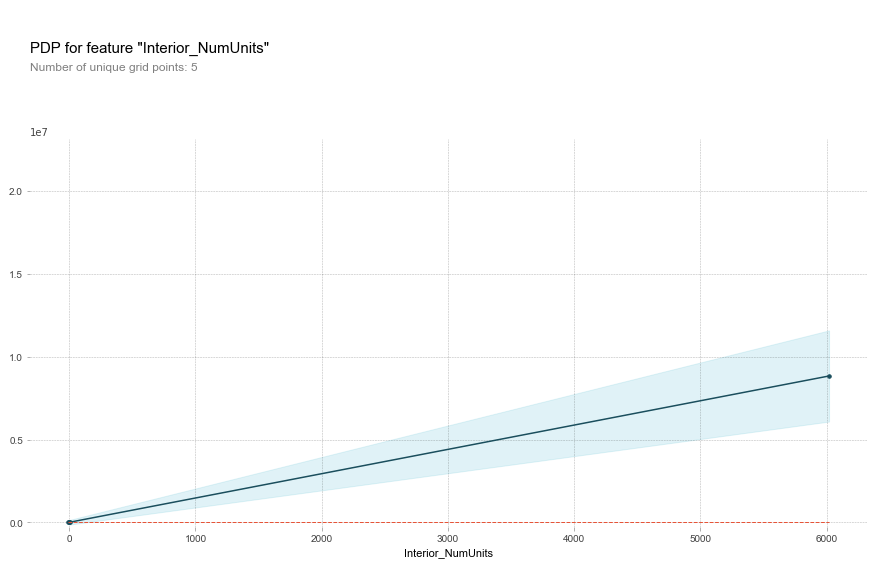

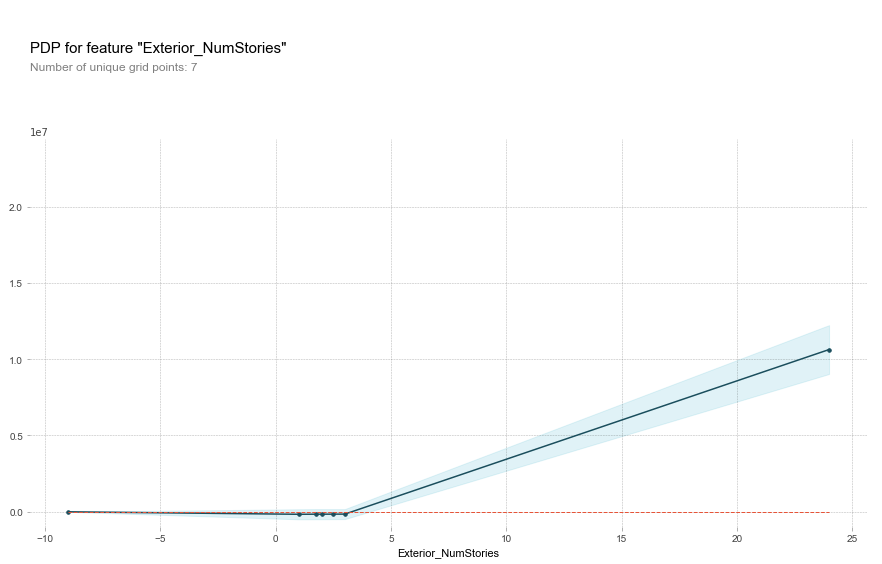

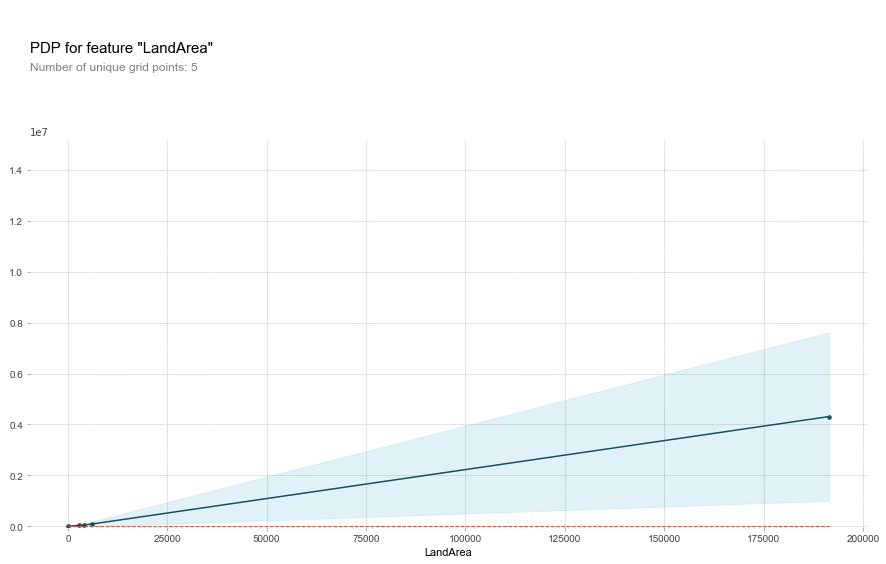

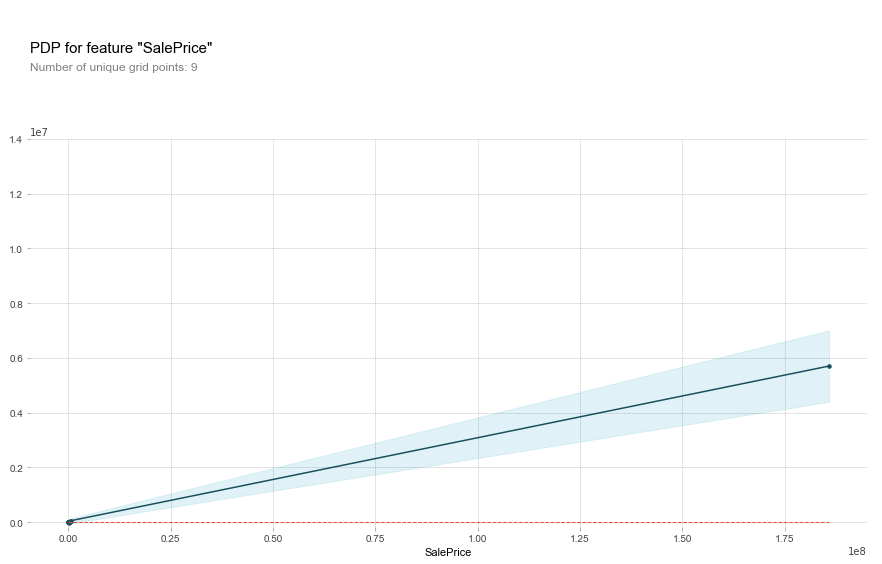

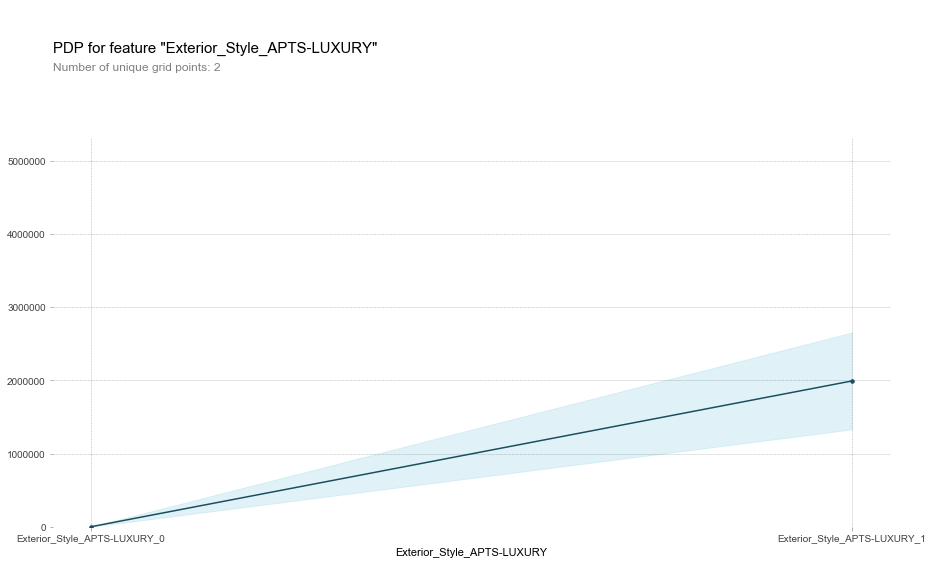

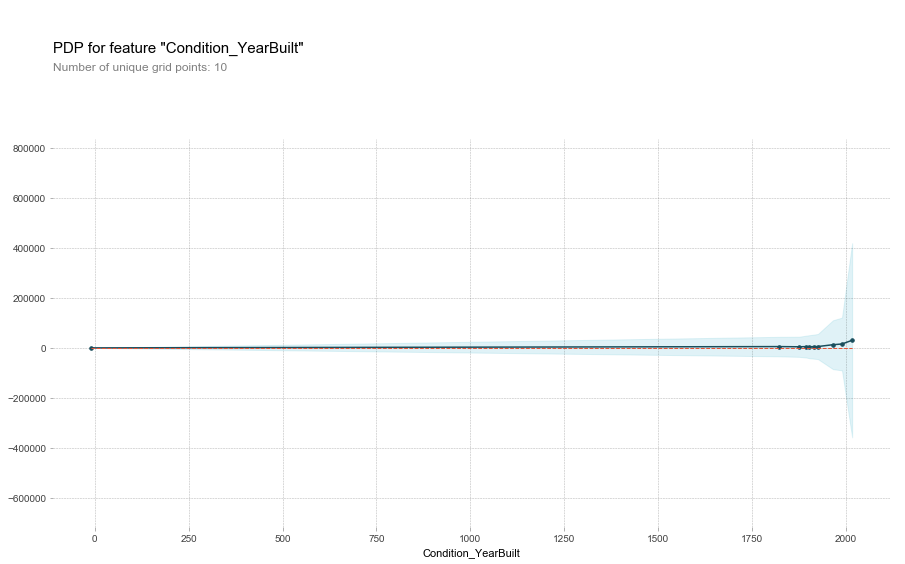

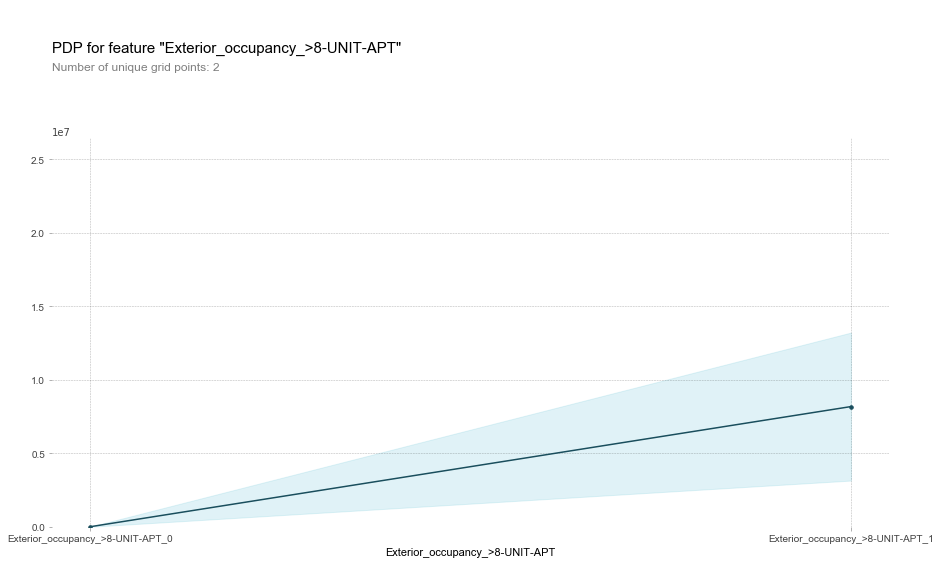

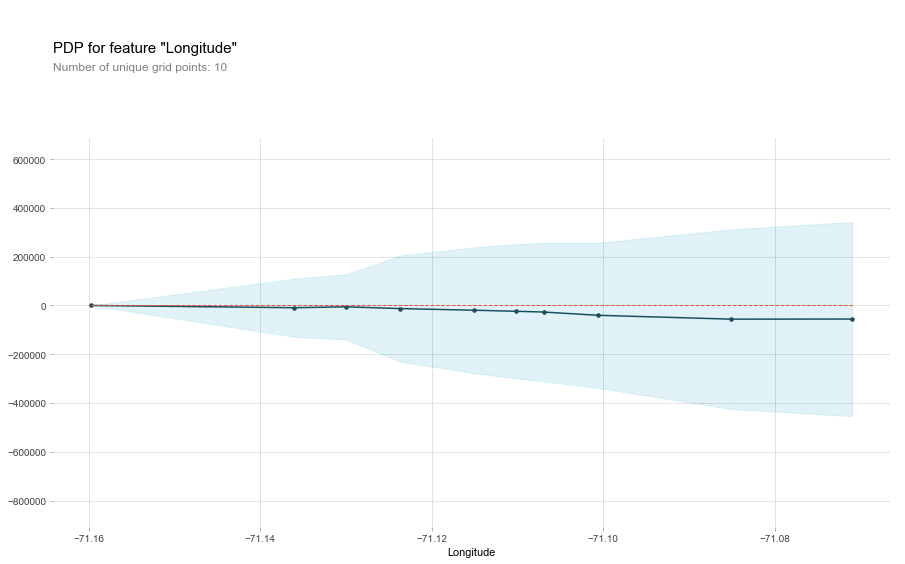

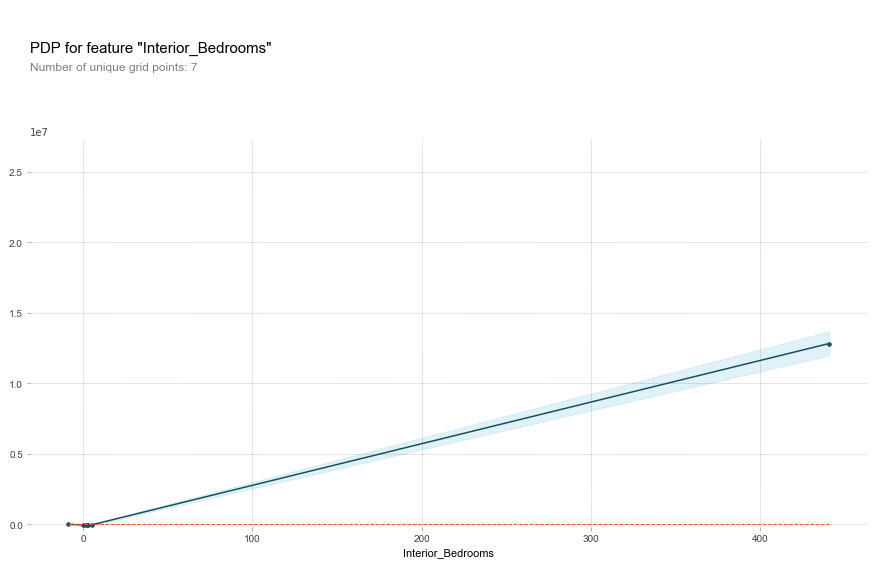

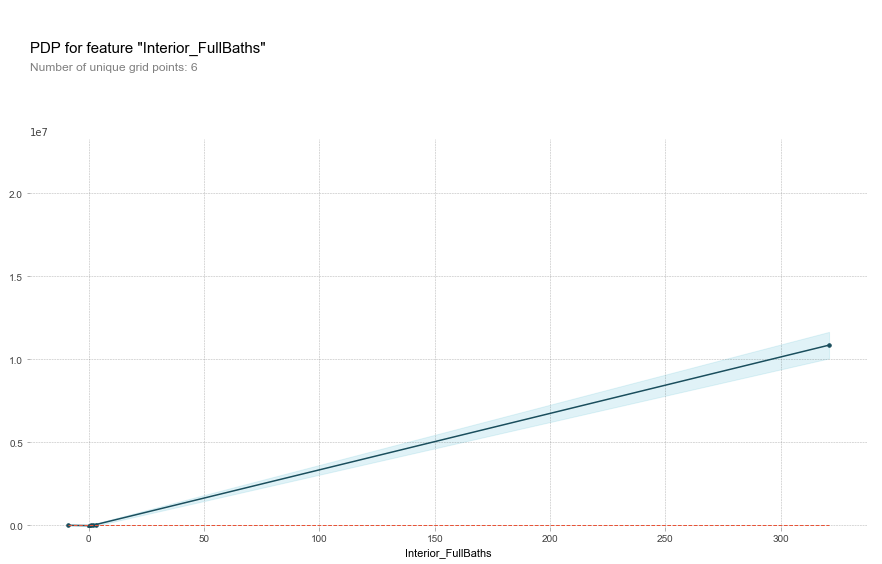

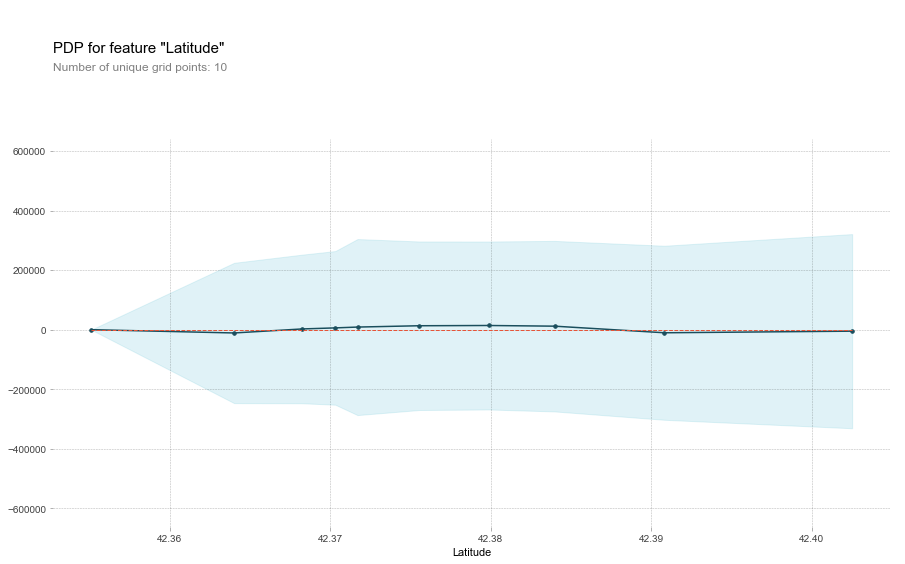

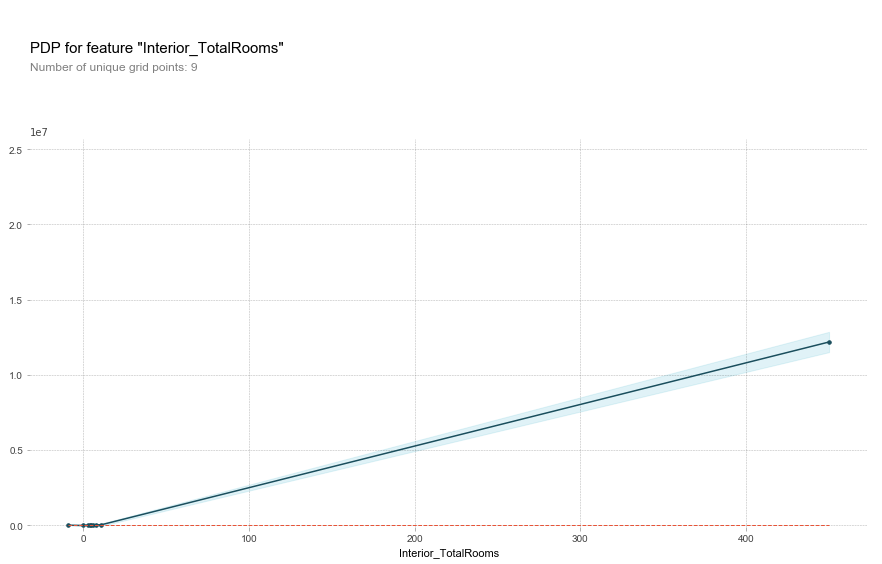

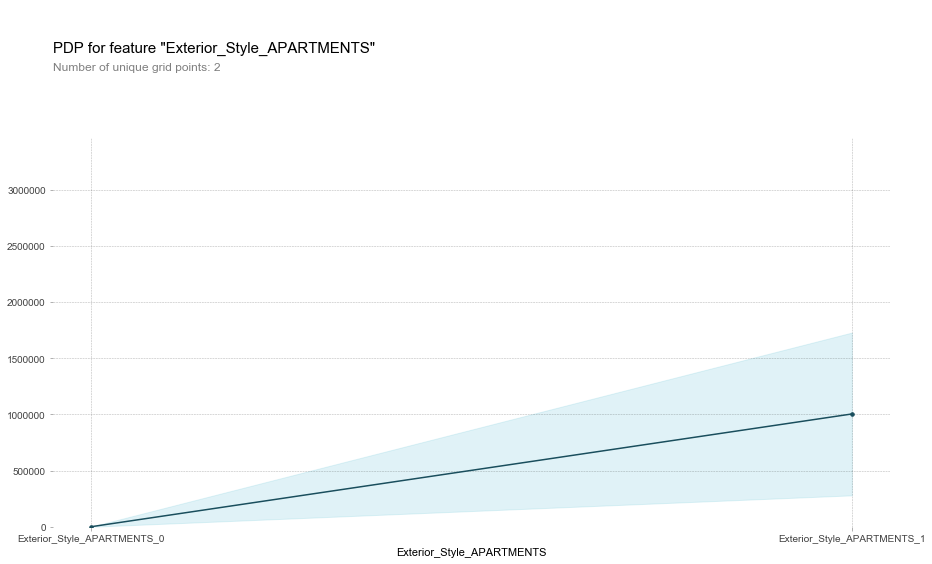

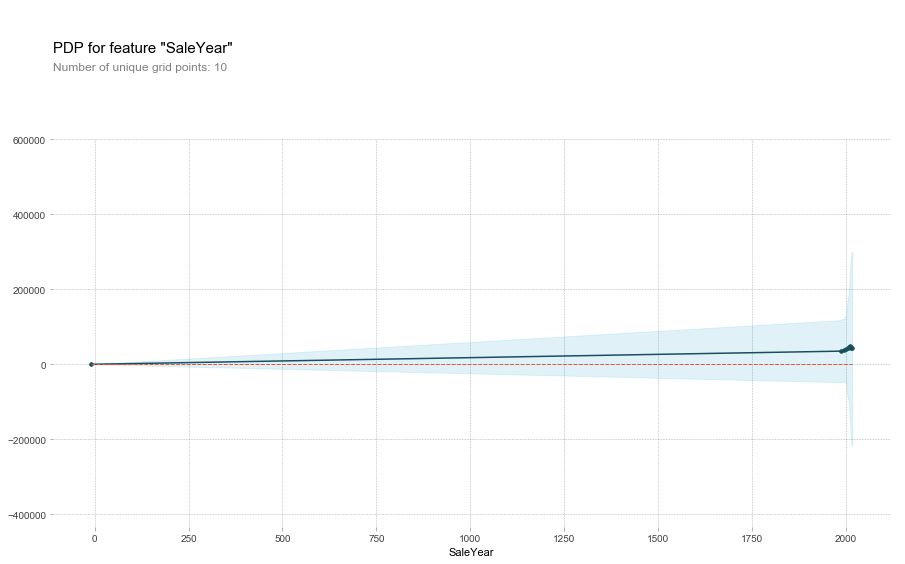

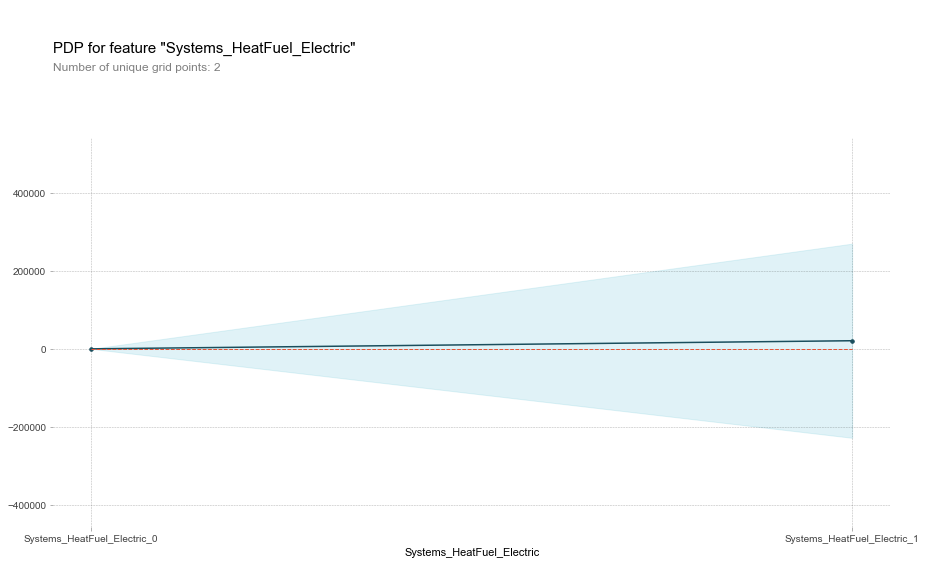

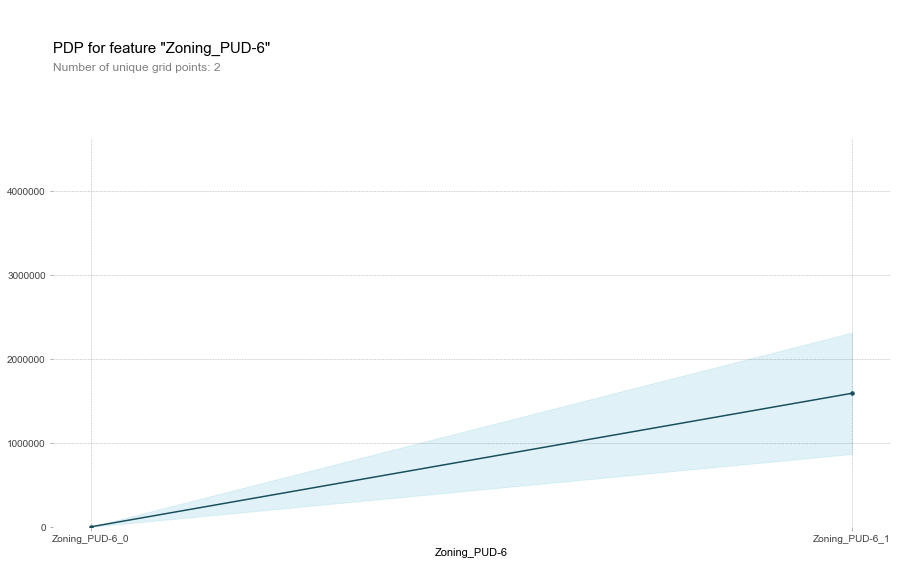

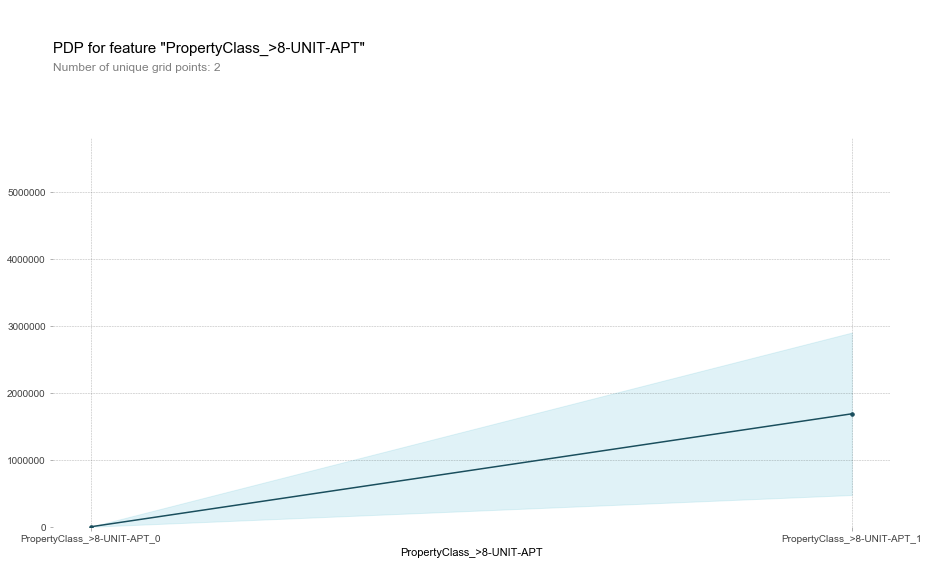

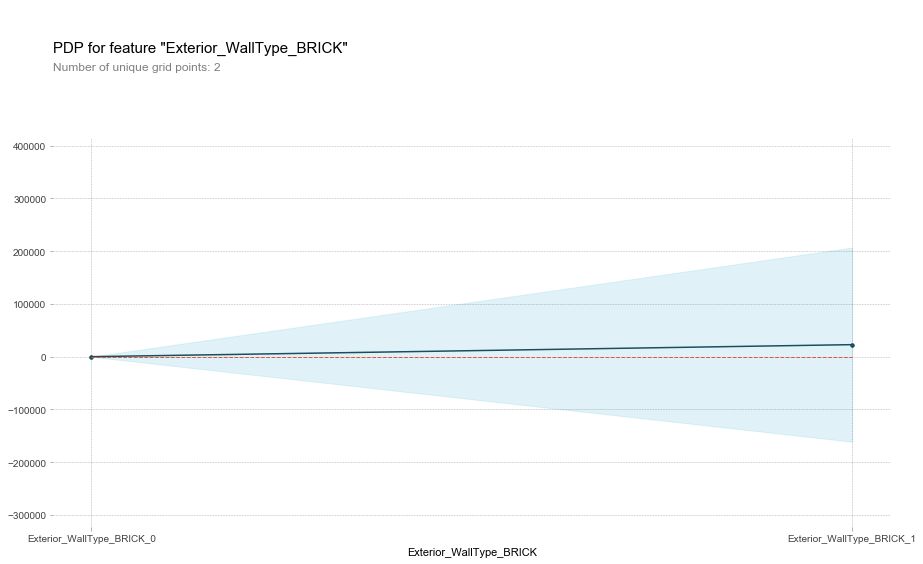

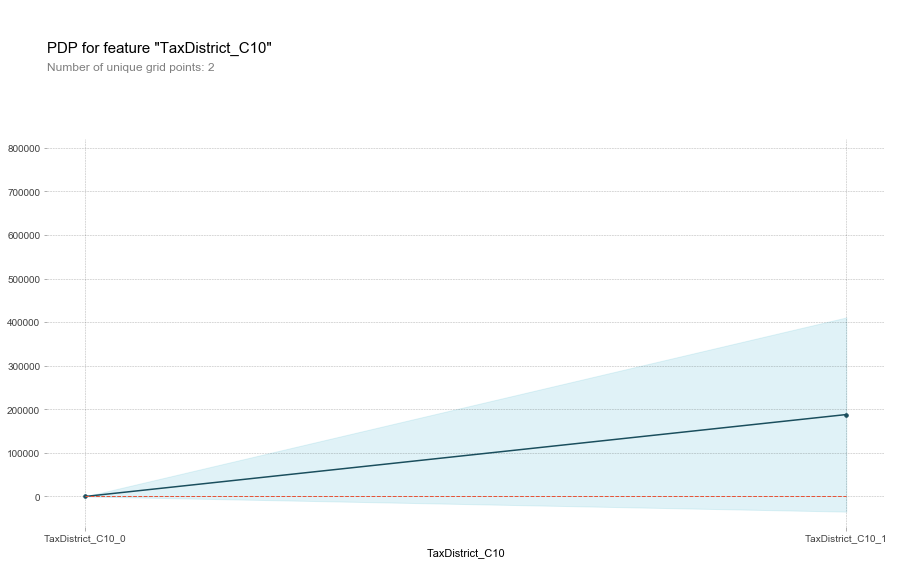

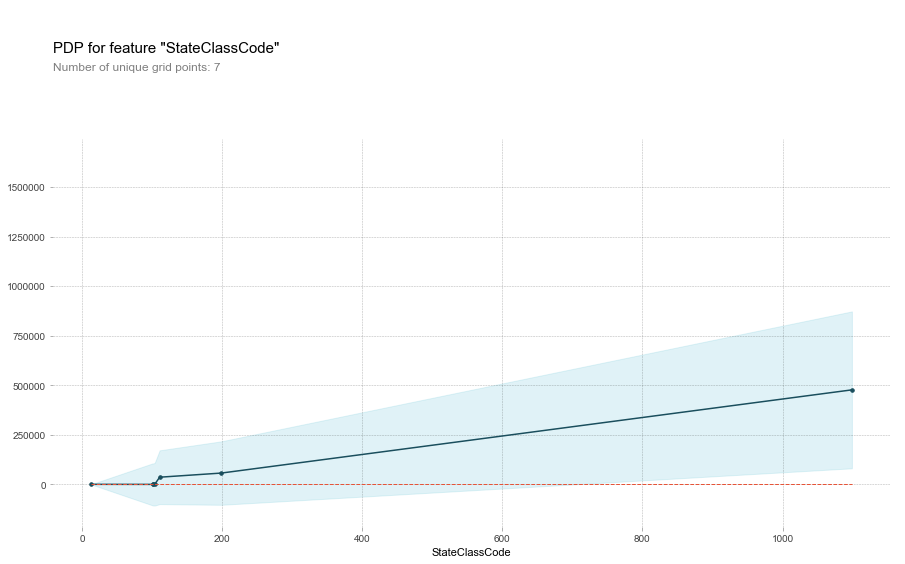

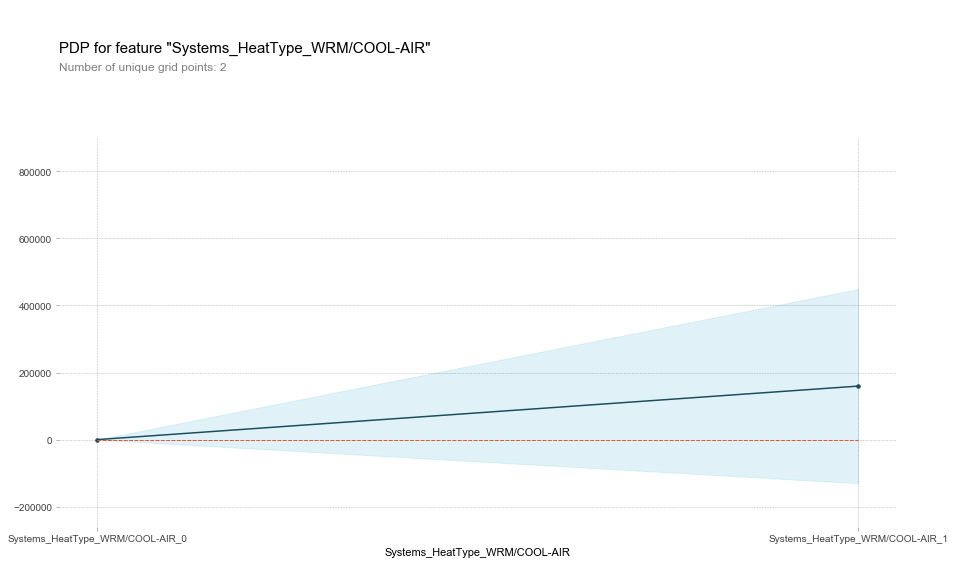

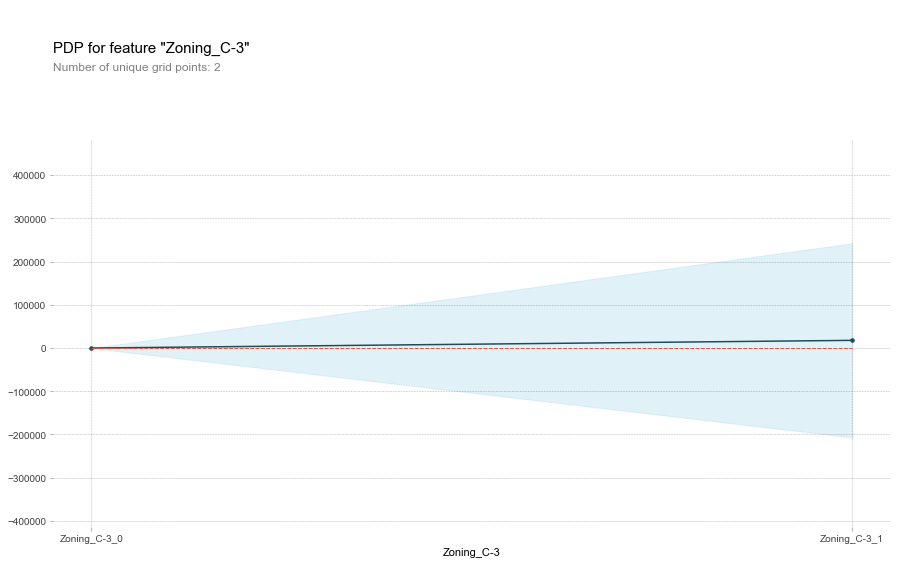

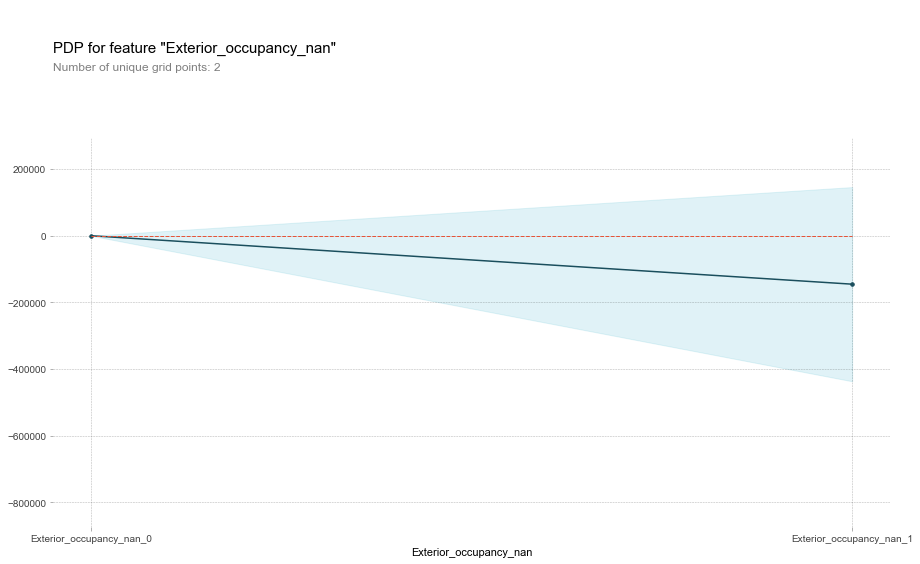

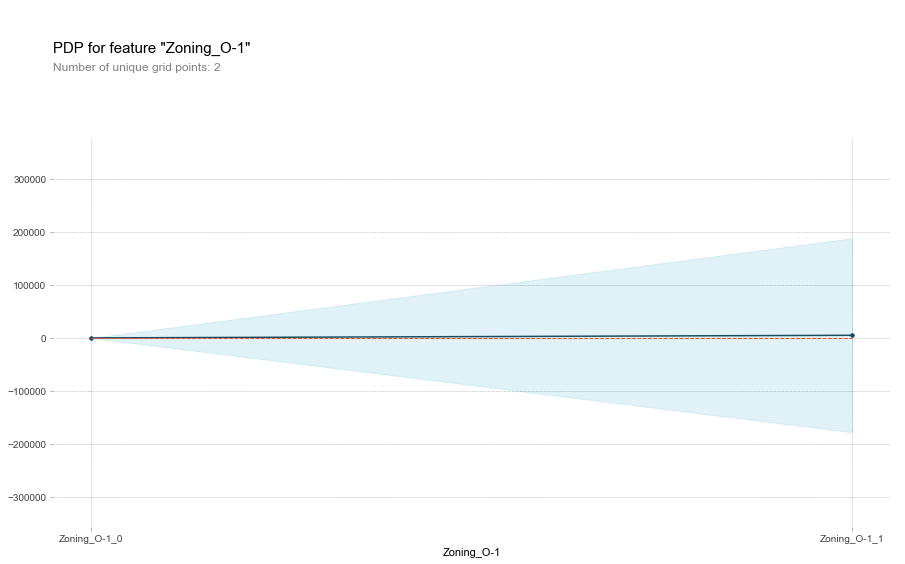

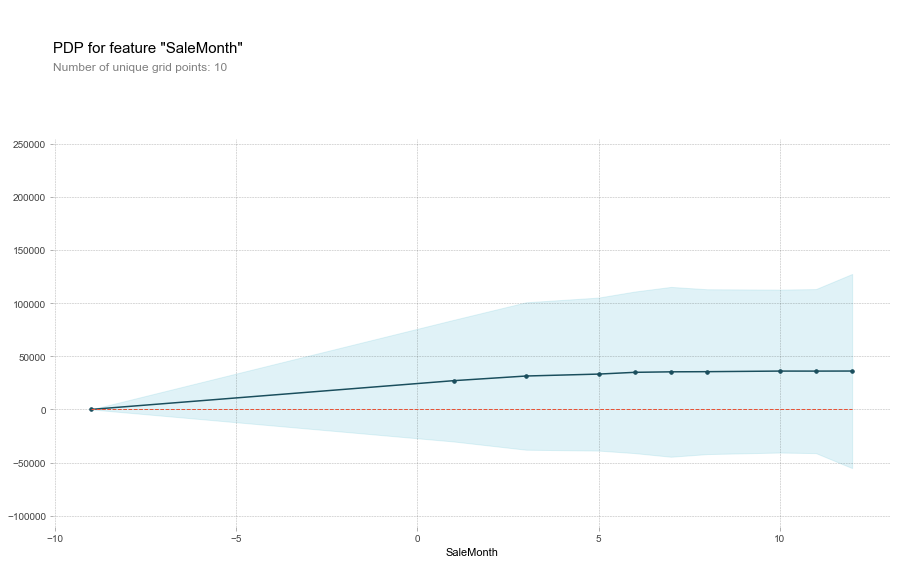

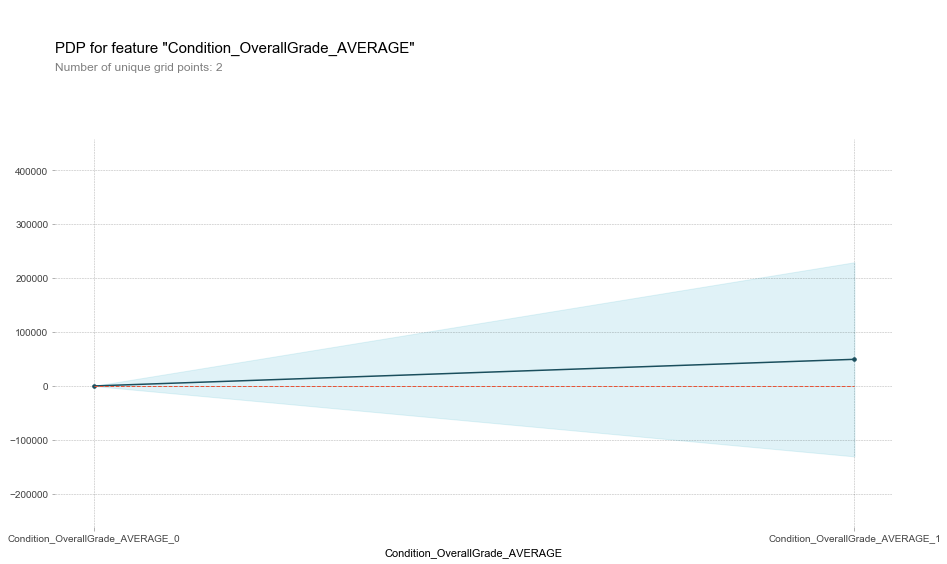

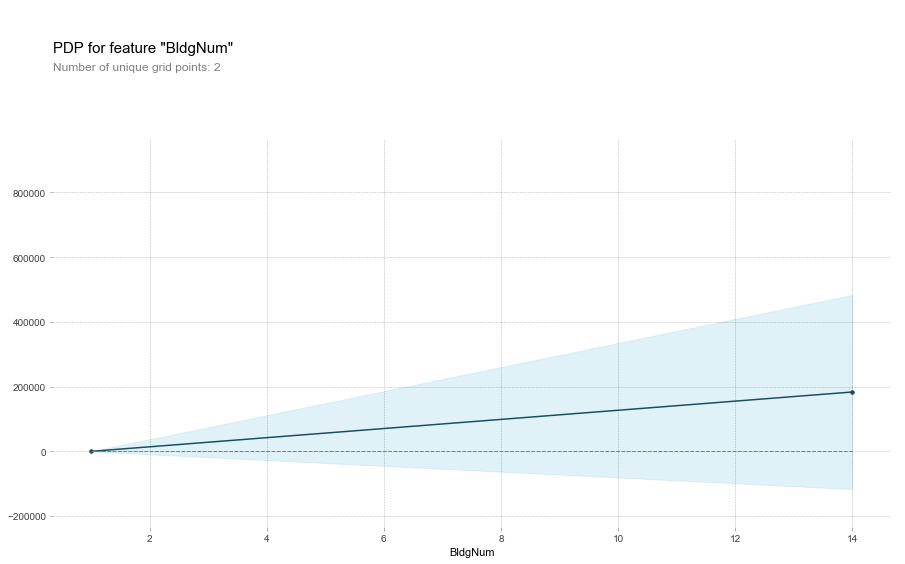

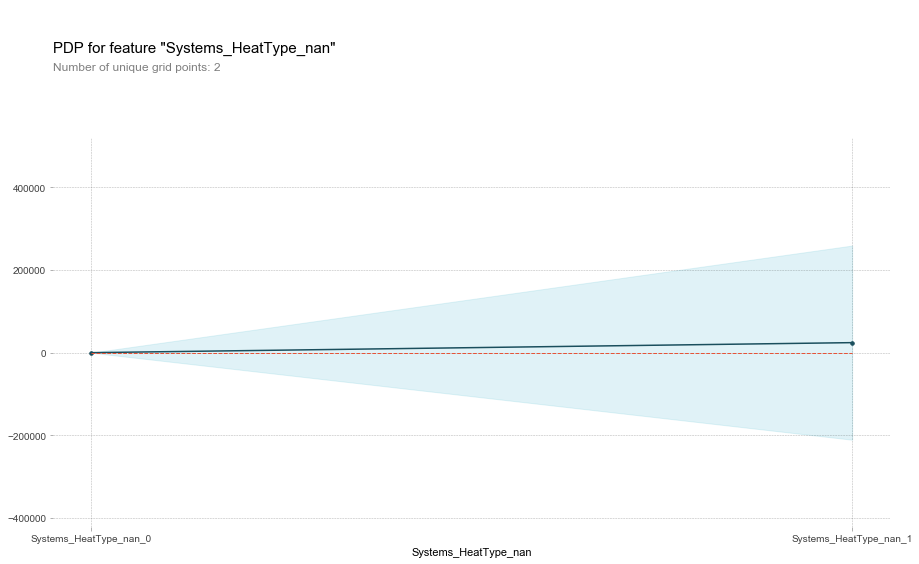

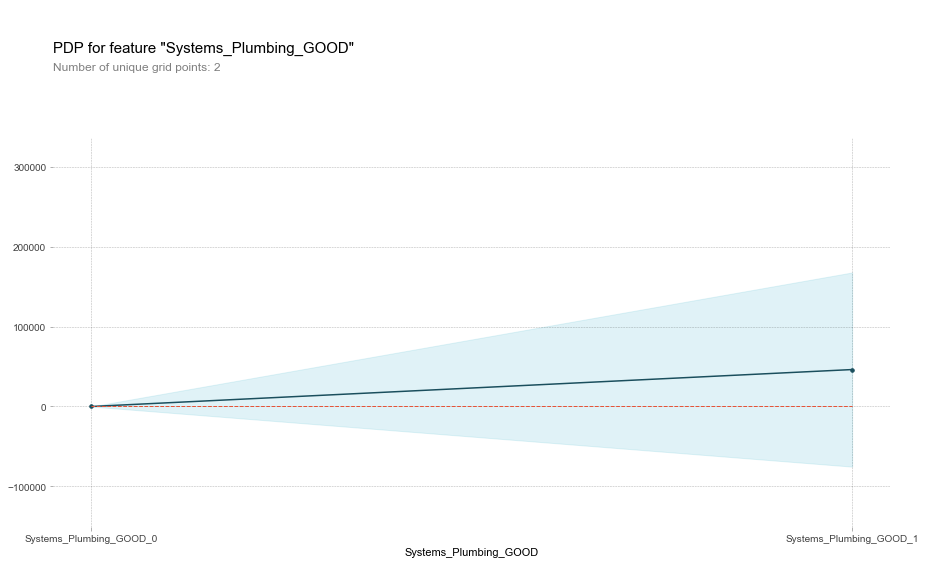

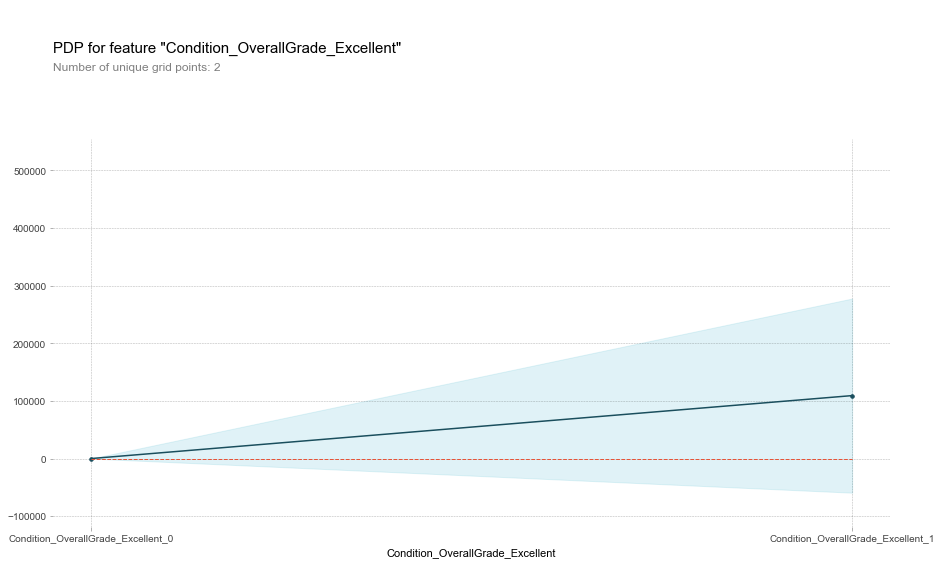

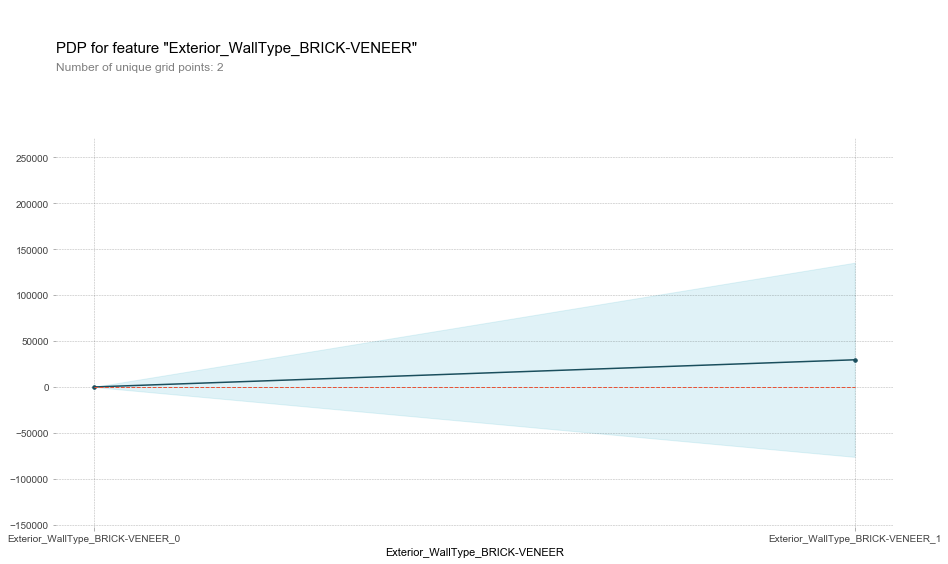

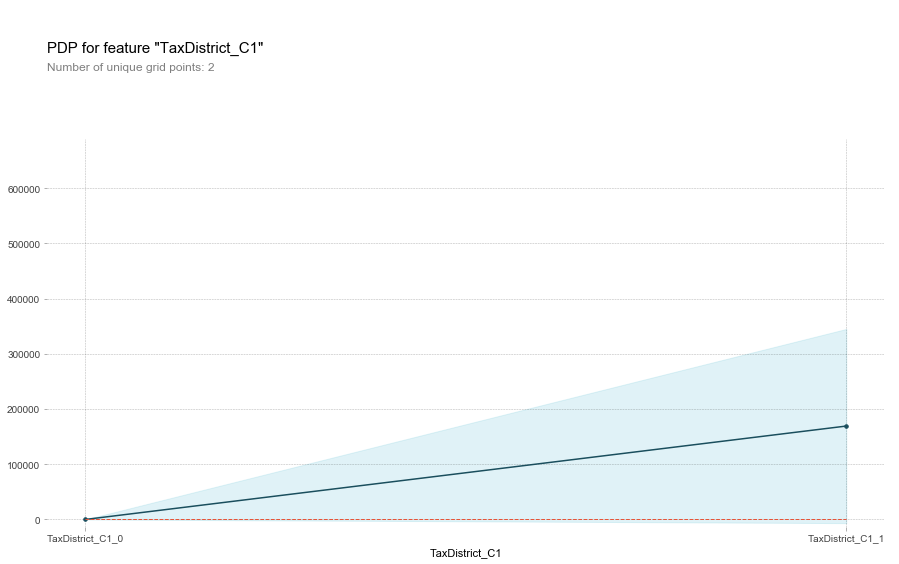

In [56]:
# loop through the features with importance higher than 0.002

for f in top_features:
    pdp_rf = pdp.pdp_isolate(model=rf, dataset=X_val, model_features=feat_names,
                         feature=f)
    pdp.pdp_plot(pdp_rf, f)
    plt.show()

In the above, I see some confusion caused by my decision to put -9 as the "invalid" value in numeric columns! This value is interpreted not as a missing value but as a point on the number line. I just have to mentally screen off those points when I look at the graphs. I also see that many of the variables have confidence bands that include 0, so "no effect", and thus they perhaps aren't wonderful predictors; alternatively, they may be good predictors that have interactions, so they look bad on 1-d PDPs.

Features that are clearly predictive by themselves:
* Interior_LivingArea
* Interior_NumUnits -- however note that one of the values is 6000, which is almost certainly a data entry error.
* Exterior_NumStories -- however, note the value of 24, which I find suspicious as well.
* LandArea
* SalePrice
* Exterior_Style_APT-LUXURY
* Exterior_Occupancy_>8-UNIT-APT
* Interior_Bedrooms -- however, the value of about 450 is suspicious.
* Interior_FullBaths
* Interior_TotalRooms
* Exterior_Syle_APARTMENTS
* Zoning_PUD-6
* PropertyClass_8-UNIT-APT
* StateClassCode

These features mostly make good sense: factors that increase the AssessedValue include values from sale, and also characteristics of big or expensive properties. It's plausible that zoning and state classification would be important, though I don't know the meanings of these codes.

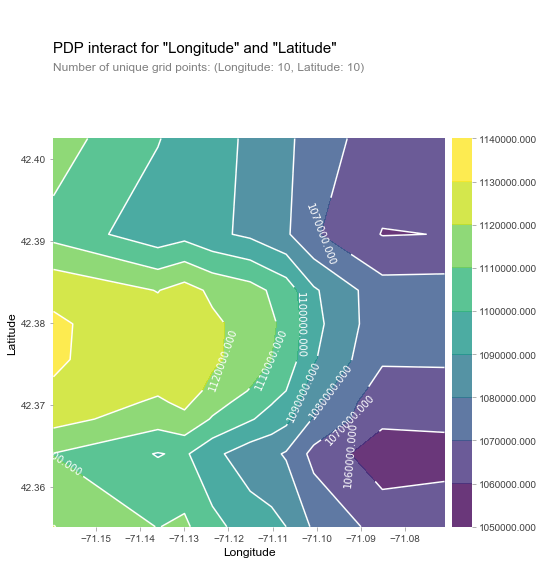

In [73]:
lonlat = ['Longitude', 'Latitude']
inter = pdp.pdp_interact(model=rf, dataset=X_val, model_features = feat_names,
                         features=lonlat)
pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=lonlat, plot_type='contour')
plt.show()


Compare the actual mapped values:

![AssessedValue_2018.png](images/AssessedValue_2018.png)

With only a 10x10 grid, there's not much chance to see a reproduction of the map here. If I squint and think optimistically, I may see the expensive neighborhood in the center-west of the city, echoed in the interaction plot. At minimum, however, this 2d-PDP does confirm an interaction between latitude and longitude.

An interesting detail here is the modest scale of the contours, ranging from 1,050,000 only up to 1,140,000 -- knowing just the latitude and longitude of a property doesn't tell you very much, compared to knowing all the other building details and especially the price history.

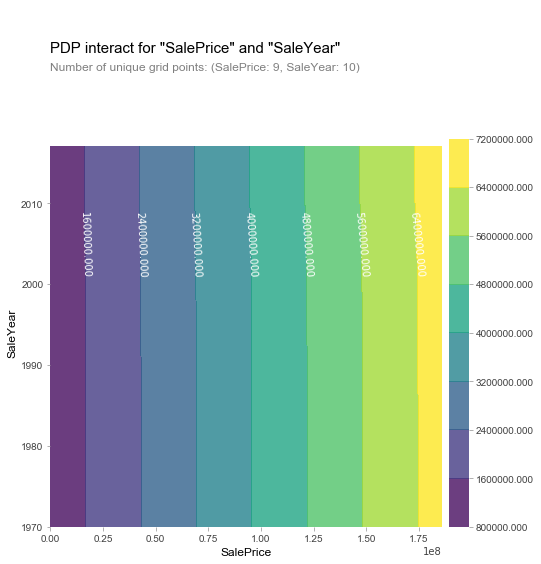

In [86]:
inter = pdp.pdp_interact(model=rf, dataset=X_val, model_features = feat_names,
                         features=['SalePrice', 'SaleYear'])
fig, ax = pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=['SalePrice', 'SaleYear'], plot_type='contour')
ax['pdp_inter_ax'].set_ylim(1970, 2018)
plt.show()

Looking at the interaction plot for SalePrice and SaleYear, we see a slight tilt to the contours, indicating an interaction. It is the expected direction: for a given SalePrice, AssessedValue is slightly higher as we go to earlier SaleYear values. That's because the price reflects an older, less expensive market.

### SHAP values

To see which features drive predictions, I tried the SHAP library. When I tried to make a SHAP explainer for the whole data set, it ran for over 30 minutes without resolution, so I killed the process. I repeated with a much smaller number of rows.

In [58]:
t1 = time.time()

explainer = shap.TreeExplainer(rf)

t2 = time.time()
print(f'Elapsed {t2-t1} seconds.')

Elapsed 4.9105260372161865 seconds.


In [59]:
shap.initjs()

In [60]:
# Since this step hung so long before, I will try it with many fewer rows

# shap_values = explainer.shap_values(X_val)

X_shap = X_val.head(50)

t1=time.time()
shap_values = explainer.shap_values(X_shap)
t2=time.time()
print(f'Elapsed {t2-t1} seconds.')

Elapsed 690.5271921157837 seconds.


With just 50 rows and the 403 columns / 100 trees in the model, calculating SHAP values took 11.5 minutes. Experimentation outside of this notebook leads me to think the calculation is roughly linear in the number of rows. It appears to be infeasible to do the full data set of 6483 rows.

In [61]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_shap.iloc[10,:])

With a rather extreme number of dummied features, the individual SHAP plots are not very readable except for the few very biggest effects. I note above "SalePrice = 1", which seems very likely to be a data entry error, or else the best real estate deal in Cambridge history.

### SHAP summary plot

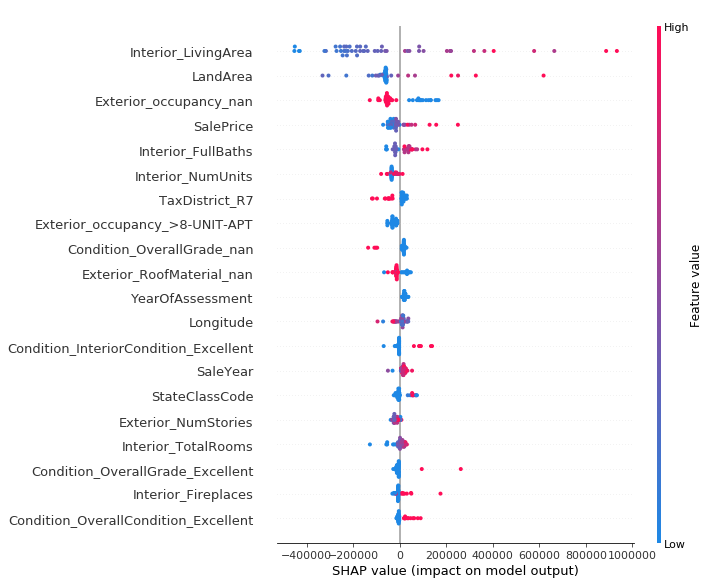

In [62]:
shap.summary_plot(shap_values, X_shap)

From the multi-feature summary plot, we see that the features with greatest influence are Living Area and Land Area, both in the intuitive directions. Interior Condition = Excellent and OverallGrade = Excellent also stand out as reasonably influential. NaN values for the categorical features seem to cause assessment decreases, which might be just due to data quality issues.

### SHAP dependence plots

In the plots below, we have SHAP value vs some features of interest, SalePrice, Interior_NumUnits, Longitude, and Interior_LivingArea, color-coded by another feature selected by the SHAP library.

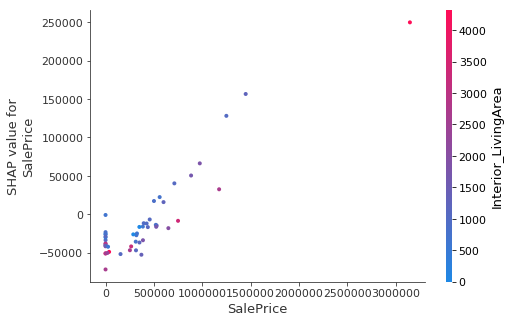

In [63]:
shap.dependence_plot('SalePrice', shap_values, X_shap)

At first glance, it looks reasonable that SHAP value and SalePrice are proportional... but check the axis scales! The slope of the line is only about 0.1, so if SalePrice increases by X, the associated rise in SHAP value is only 0.1X. So SalePrice has a lot less importance than I might have thought. This is perhaps explained by the SaleDate being potentially quite far in the past.

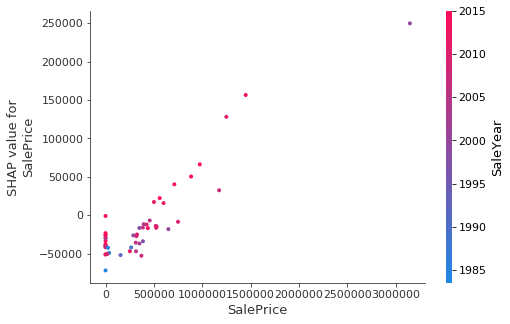

In [71]:
shap.dependence_plot('SalePrice', shap_values, X_shap, interaction_index=6)

However, plotting SaleYear explictly doesn't seem to support that explanation, since most of the SaleYear points are quite recent. It's possible that the large number of SalePrice == 0 rows are damping the effect.

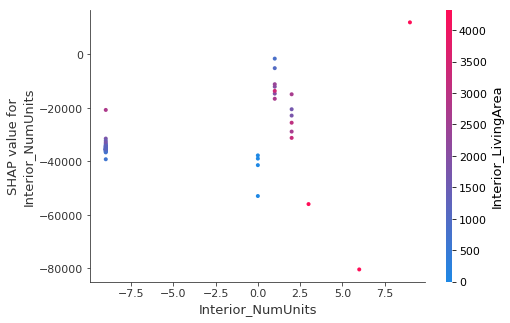

In [64]:
shap.dependence_plot('Interior_NumUnits', shap_values, X_shap)

The dependence plot for NumUnits is just confusing.

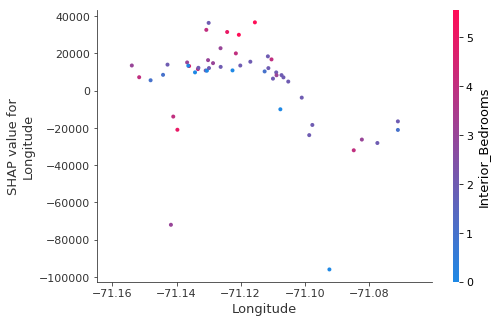

In [65]:
shap.dependence_plot('Longitude', shap_values, X_shap)

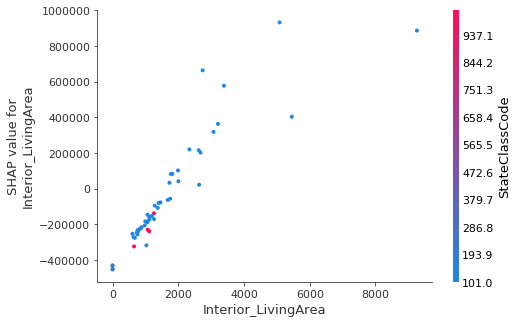

In [66]:
shap.dependence_plot('Interior_LivingArea', shap_values, X_shap)

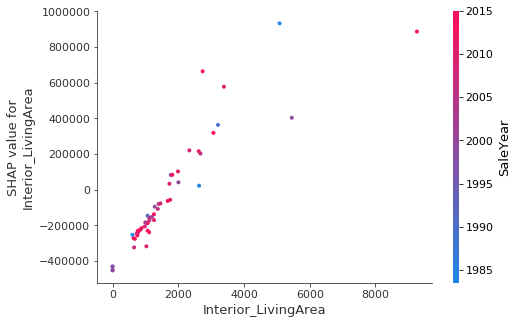

In [72]:
shap.dependence_plot('Interior_LivingArea', shap_values, X_shap, interaction_index = 6)

LivingArea, as the strongest feature, also has a very clear linear trend, except for the few very large properties.

## Conclusions

* The data set had a lot of invalid values, affecting over 60% of the rows. These are very probably data entry issues; as described in the ETLC notebook, many of the rows are affected by a "frame shift" error, in which the start of the row is valid, but then values began to appear in columns next to the intended column, throwing off the whole remainder of the row.
* Despite these issues, a random forest model achieved about 7% relative error in predicting AssessedValue for the held-out validation set. If allowed to lean on the PreviousAssessedValue feature, which may be a bit of a cheat, relative error fell to about 3.5%.
* By inspecting the residuals, I identified a large class of rows that were spoiled by invalid values. I didn't find any other major systematic errors or other glaring issues. The relative error -- i.e. error scaled to the known true value -- didn't have a systematic scale dependence.
* Using several methods to explore the function of the model -- feature importance, permutation importance, partial dependence plots, and SHAP values -- I identified the top few drivers of the model, and found that they mostly contributed in the intuitive way. For example, properties that recently sold for a higher price, that are larger, or that were assessed at a higher value in the previous year, all tended to receive higher AssessedValue.